In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/home/jupyter/checkmate-histo/consolidated_workflow/immunoprofile_analysis/')

from imports import *
import xarray
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
# import plotly.express as px

set_rc()

from skimage.io import imread
from deepcell.applications import Mesmer

qptiff_channels = ['dapi', 'foxp3', 'tumor_specific', 'cd8', 'pd1', 'pdl1','autofluorescence']

gating_cols = ['cd8_gate','tumor_gate']

morph_fts = [
    'centroid_dif', # asymmetry ??
    'num_concavities', # "concavities"
    'convex_hull_resid', # I think this is "Fill"
    'major_axis_equiv_diam_ratio', # "aspect ratio"
    'perim_square_over_area', # "perimeter to area ratio"
    'arcsinh_area',
]

gating_cols = ['tumor_gate','cd8_gate']

feature_cols = qptiff_channels + morph_fts

candidates = pd.read_csv('./immunoprofile_hne_rag_features__passing_14_subset.csv', index_col=0)

candidates = candidates.drop('IP_19_E00218')

In [2]:
MH_ORDER = ['Homog.', 'Het.']
PALETTE = 'colorblind'

In [3]:
subset_agg = pd.read_csv('./immune_hotspot_topk_cellwise_data__subset_agg.csv')

In [4]:
detailed_interation_names  =[
    'Tumor+ PDL1 High [Self]',
    'Tumor+ PDL1 Low [Self]',
    'Tumor+ PDL1 High/Low',
    'Tumor+ PDL1 High vs CD8+ PD1 High',
    'Tumor+ PDL1 High vs CD8+ PD1 Low',
    'Tumor+ PDL1 Low vs CD8+ PD1 High',
    'Tumor+ PDL1 Low vs CD8+ PD1 Low',
    'CD8+ PD1 High [Self]',
    'CD8+ PD1 High/Low',
    'CD8+ PD1 Low [Self]'
]

In [5]:
def sweep_exclusions_hardcode(df):
    sweep = {
        'base':df,
        'Remove IP_19_K00367':df.loc[(df['case_id'] != 'IP_19_K00367')],
        'Remove IP_19_K00367 and LN':df.loc[(df['biopsySite'] != 'Lymphoid') & (df['case_id'] != 'IP_19_K00367')],
    }
    return sweep

def add_log10_density(df, col):
    df[f'log10({col} + 1)'] = np.log10(df[col] + 1)

In [6]:
for tc_sub in ['Tumor+ PDL1 High','Tumor+ PDL1 Low']:
    crit = (subset_agg['edge_context'] == 'Tumor-Immune Interaction') & (subset_agg['detailed_cell_type'] == tc_sub)
    crit = crit & (subset_agg[f'{tc_sub} vs CD8+ PD1 High'] > 0)
    subset_agg.loc[crit, 'detailed_cell_context'] = f'{tc_sub} : CD8+ PD1 High'

    crit = (subset_agg['edge_context'] == 'Tumor-Immune Interaction') & (subset_agg['detailed_cell_type'] == tc_sub)
    crit = crit & (subset_agg[f'{tc_sub} vs CD8+ PD1 Low'] > 0)
    subset_agg.loc[crit, 'detailed_cell_context'] = f'{tc_sub} : CD8+ PD1 Low'

ic_sub = 'CD8+ PD1 High'
for ic_sub in ['CD8+ PD1 High','CD8+ PD1 Low']:
    crit = (subset_agg['edge_context'] == 'Tumor-Immune Interaction') & (subset_agg['detailed_cell_type'] == ic_sub)
    crit = crit & (subset_agg[f'Tumor+ PDL1 High vs {ic_sub}'] > 0)
    subset_agg.loc[crit, 'detailed_cell_context'] = f'{ic_sub} : Tumor+ PDL1 High'

    crit = (subset_agg['edge_context'] == 'Tumor-Immune Interaction') & (subset_agg['detailed_cell_type'] == ic_sub)
    crit = crit & (subset_agg[f'Tumor+ PDL1 Low vs {ic_sub}'] > 0)
    subset_agg.loc[crit, 'detailed_cell_context'] = f'{ic_sub} : Tumor+ PDL1 Low'



for dct in ['Tumor+ PDL1 High','Tumor+ PDL1 Low','CD8+ PD1 High','CD8+ PD1 Low']:
    crit = (subset_agg['edge_context'] != 'Tumor-Immune Interaction') & (subset_agg['detailed_cell_type'] == dct)
    subset_agg.loc[crit, 'detailed_cell_context'] = f'{dct} : Self'


subset_agg['detailed_cell_context'] = subset_agg['detailed_cell_context'].astype('category')

In [7]:
counts_full = pd.DataFrame()
for idx, sub in subset_agg.groupby(['case_id','microhet','px','py']):
    subcounts = sub['detailed_cell_context'].value_counts()
    reformat = subcounts.reset_index().rename(columns={'index':'detailed_cell_context', 'detailed_cell_context':'count'})
    
    for val, col in zip(idx, ['case_id','microhet','px','py']):
        reformat[col] = val
        
    counts_full = pd.concat([counts_full, reformat])

In [8]:
(counts_full['count'] == 0).sum()

62

In [9]:
dcc_counts = counts_full.copy()
dcc_counts['Density'] = dcc_counts['count']
dcc_counts = dcc_counts.reset_index()

dcc_counts['cell_type'] = dcc_counts['detailed_cell_context'].apply(lambda x: x.split(' ')[0])
dcc_counts['subtype_high'] = dcc_counts['detailed_cell_context'].apply(lambda x: x.split(' ')[2])

dcc_counts['self'] = dcc_counts['detailed_cell_context'].apply(lambda x: x.split(' ')[-1] == 'Self').map({False:'TI',True:'Self'})
dcc_counts['partner'] = dcc_counts['detailed_cell_context'].apply(lambda x: x.split(' : ')[1])

dcc_counts = dcc_counts.set_index('case_id').join(candidates['biopsySite']).reset_index()
dcc_counts['detailed_cell_type'] = dcc_counts['detailed_cell_context'].apply(lambda x: x.split(' : ')[0])

dct_counts = dcc_counts.groupby(['case_id','microhet','biopsySite','px','py','detailed_cell_type',])['count'].sum().reset_index()
ct_counts = dcc_counts.groupby(['case_id','microhet','biopsySite','px','py','cell_type',])['count'].sum().reset_index()


# collapsed CD8+
collapsed_cd8_counts = dcc_counts.loc[dcc_counts['cell_type'] == 'CD8+']
collapsed_cd8_counts = collapsed_cd8_counts.groupby(['case_id','microhet','biopsySite','px','py','cell_type','self','partner'])['count'].sum().reset_index()
collapsed_cd8_counts['collapsed_cd8_cell_type'] = 'CD8+'

collapsed_cd8_tumor_comp =  dcc_counts.loc[dcc_counts['cell_type'] == 'Tumor+'].groupby(
    ['case_id','microhet','biopsySite','px','py','cell_type','detailed_cell_type','self',])['count'].sum().reset_index()

crit = collapsed_cd8_tumor_comp['self'] == 'Self'
collapsed_cd8_tumor_comp.loc[crit, 'partner'] = 'Self'
collapsed_cd8_tumor_comp['collapsed_cd8_cell_type'] = collapsed_cd8_tumor_comp['detailed_cell_type']

collapsed_cd8_tumor_comp.loc[collapsed_cd8_tumor_comp['self'] == 'TI', 'partner'] = 'CD8+'
collapsed_cd8_counts = pd.concat([collapsed_cd8_counts, collapsed_cd8_tumor_comp])


In [10]:
# collapsed tumor

collapsed_tumor_counts = dcc_counts.loc[dcc_counts['cell_type'] == 'Tumor+']
collapsed_tumor_counts = collapsed_tumor_counts.groupby(['case_id','microhet','biopsySite','px','py','cell_type','self','partner'])['count'].sum().reset_index()
collapsed_tumor_counts['collapsed_tumor_cell_type'] = 'Tumor+'

collapsed_tumor_cd8_comp =  dcc_counts.loc[dcc_counts['cell_type'] == 'CD8+'].groupby(
    ['case_id','microhet','biopsySite','px','py','cell_type','detailed_cell_type','self',])['count'].sum().reset_index()

crit = collapsed_tumor_cd8_comp['self'] == 'Self'
collapsed_tumor_cd8_comp.loc[crit, 'partner'] = 'Self'
collapsed_tumor_cd8_comp['collapsed_tumor_cell_type'] = collapsed_tumor_cd8_comp['detailed_cell_type']

collapsed_tumor_cd8_comp.loc[collapsed_tumor_cd8_comp['self'] == 'TI', 'partner'] = 'Tumor+'
collapsed_tumor_counts = pd.concat([collapsed_tumor_counts, collapsed_tumor_cd8_comp])

In [11]:
# CT EC 
ct_ec_counts = dcc_counts.groupby(['case_id','microhet','biopsySite','px','py','cell_type','self'])['count'].sum().reset_index()
ct_ec_counts['ct_ec'] = ct_ec_counts['cell_type'] + ' : ' + ct_ec_counts['self']

In [12]:
collapsed_tumor_counts

,case_id,microhet,biopsySite,px,py,cell_type,self,partner,count,collapsed_tumor_cell_type,detailed_cell_type
0,IP_18_A00093,Homog.,None,12.0,6.0,Tumor+,Self,Self,675,Tumor+,NaN
1,IP_18_A00093,Homog.,None,12.0,6.0,Tumor+,TI,CD8+ PD1 High,110,Tumor+,NaN
2,IP_18_A00093,Homog.,None,12.0,6.0,Tumor+,TI,CD8+ PD1 Low,155,Tumor+,NaN
3,IP_18_A00093,Homog.,None,13.0,7.0,Tumor+,Self,Self,582,Tumor+,NaN
4,IP_18_A00093,Homog.,None,13.0,7.0,Tumor+,TI,CD8+ PD1 High,175,Tumor+,NaN
...,...,...,...,...,...,...,...,...,...,...,...
391,IP_20_M00245,Homog.,Kidney,17.0,12.0,CD8+,TI,Tumor+,105,CD8+ PD1 Low,CD8+ PD1 Low
392,IP_20_M00245,Homog.,Kidney,17.0,15.0,CD8+,Self,Self,11,CD8+ PD1 High,CD8+ PD1 High
393,IP_20_M00245,Homog.,Kidney,17.0,15.0,CD8+,TI,Tumor+,44,CD8+ PD1 High,CD8+ PD1 High
394,IP_20_M00245,Homog.,Kidney,17.0,15.0,CD8+,Self,Self,16,CD8+ PD1 Low,CD8+ PD1 Low


In [13]:
for d in [dcc_counts, ct_counts, dct_counts, collapsed_cd8_counts, ct_ec_counts, collapsed_tumor_counts]:
    d['Density'] = d['count']
    d['log10(Density + 1)'] = np.log10(d['Density'] + 1)


### Add cell type overall density to detailed cell context counts

In [14]:
ref_total_density = ct_counts.set_index(['case_id','px','py','cell_type'])['Density']
ref_total_density.name = 'Total Density'

tmp = dcc_counts.set_index(['case_id','px','py','cell_type']).join(ref_total_density).reset_index()
tmp['Density Fraction'] = tmp['Density']/tmp['Total Density']
tmp['DCC'] = tmp['detailed_cell_context'].astype(str)

### Collapse CD8 and then check residuals again

In [15]:
ref_total_density = ct_counts.set_index(['case_id','px','py','cell_type'])['Density']
ref_total_density.name = 'Total Density'

tmp_collapsed_cd8 = collapsed_cd8_counts.set_index(['case_id','px','py','cell_type']).join(ref_total_density).reset_index()
tmp_collapsed_cd8['Density Fraction'] = tmp_collapsed_cd8['Density']/tmp_collapsed_cd8['Total Density']
tmp_collapsed_cd8['DCC'] = tmp_collapsed_cd8['collapsed_cd8_cell_type'] + ' : ' + tmp_collapsed_cd8['partner']

In [16]:
for d in [tmp, tmp_collapsed_cd8]:
    for col in ['Density','Total Density']:
        add_log10_density(d, col)

In [230]:
scattered_results = {}

In [231]:
dcc_counts.drop_duplicates(['case_id','px','py']).value_counts(['microhet'])

microhet
Homog.      57
Het.        42
dtype: int64

In [232]:
dcc_counts.drop_duplicates(['case_id',]).value_counts(['microhet'])

microhet
Homog.      6
Het.        5
dtype: int64

In [233]:
dcc_counts.drop_duplicates(['case_id','px','py']).value_counts(['case_id'])

case_id     
IP_18_A00093    10
IP_19_D00209    10
IP_19_F00568    10
IP_19_J00132    10
IP_19_K00058    10
IP_19_K00367    10
IP_19_R00053    10
IP_20_F00356    10
IP_20_M00245    10
IP_19_T00810     7
IP_19_G00660     2
dtype: int64

In [234]:
dcc_counts.drop_duplicates(['case_id','px','py']).value_counts(['case_id']).describe()

count    11.00000
mean      9.00000
std       2.48998
min       2.00000
25%      10.00000
50%      10.00000
75%      10.00000
max      10.00000
dtype: float64

### Compare base densities without TI context

In [235]:
TEST = 'Mann-Whitney'
TEXT_FORMAT = 'star'



 base
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Tumor+_Homog. vs. Tumor+_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:9.661e-01 U_stat=1.204e+03
CD8+_Homog. vs. CD8+_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:3.165e-02 U_stat=8.930e+02


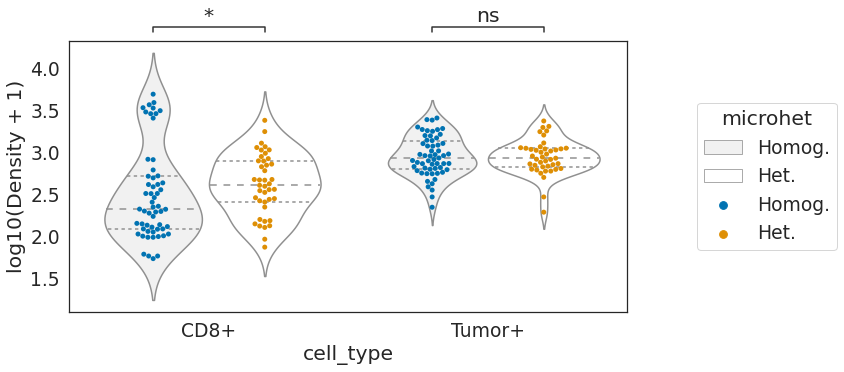



 Remove IP_19_K00367
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Tumor+_Homog. vs. Tumor+_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:4.595e-01 U_stat=1.078e+03
CD8+_Homog. vs. CD8+_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:2.439e-05 U_stat=4.730e+02


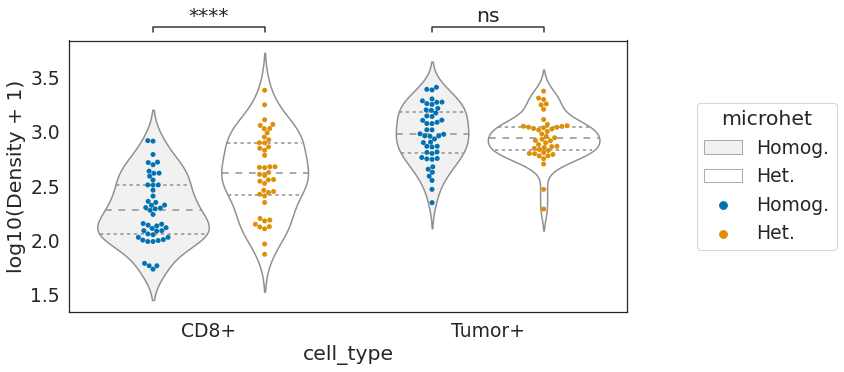



 Remove IP_19_K00367 and LN
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Tumor+_Homog. vs. Tumor+_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:3.883e-01 U_stat=4.495e+02
CD8+_Homog. vs. CD8+_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:5.585e-02 U_stat=3.680e+02


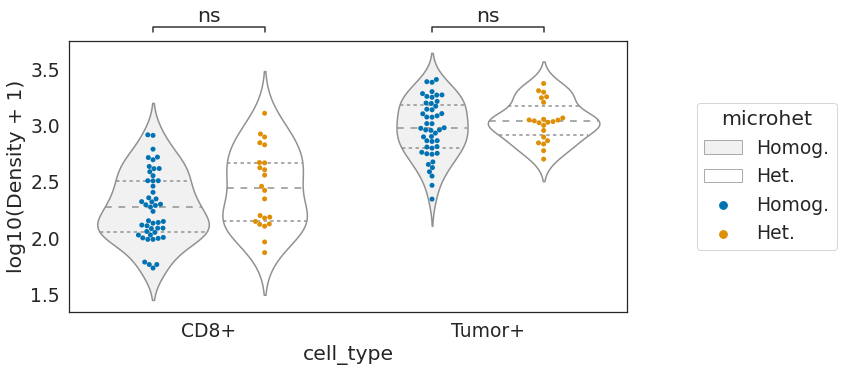

In [236]:
plot_marginals = False
fit_intercept = True
tmp_sweep = sweep_exclusions_hardcode(ct_counts)
for k, filtered_df in tmp_sweep.items():
    print(f'\n\n ====== \n {k}')
    
    for y in ['log10(Density + 1)']:
        plot_kws = {
            'order':None,
            'y':y,
            'x':'cell_type',
            'order':np.sort(filtered_df['cell_type'].unique()),
            'hue':'microhet',
            'hue_order':MH_ORDER,
            'data':filtered_df,
        }

        i = plot_kws['data'][plot_kws['x']].unique()
        j = plot_kws['data'][plot_kws['hue']].unique()

        set_rc(int(5*len(i)),5, 1.7 )

        pairs = make_statannotations_pairs(i,j,'inner')

        g = sns.violinplot(**plot_kws, inner='quartile',  color='white')
        annotator = Annotator(g, pairs, **plot_kws)
        annotator.configure(test=TEST, text_format= TEXT_FORMAT, loc='outside')
        annotator.apply_and_annotate()


        g = sns.swarmplot(**plot_kws,dodge=True, )
        move_legend(g, xy=(1.25, 0.5))
        f = f'./figures/density_in_base_ct__no_ti_context__({k})'
        flex_save(f, dpi=400)
        plt.show()
        
        unpacked_pvals = unpack_annotator(annotator)
        pval_str = f'[Supp] [({annotator.test} {annotator.text_format})] density_in_base_ct__no_ti_context__({k})'
        scattered_results[pval_str] = unpacked_pvals
        
        median_str = f'[Supp] [MH Medians] density_in_base_ct__no_ti_context__({k})'
        median_val = plot_kws['data'].groupby([plot_kws['x'], 'microhet'])[plot_kws['y']].median()
        scattered_results[median_str] = median_val

### Compare base densities with TI context 



 base
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CD8+ : TI_Homog. vs. CD8+ : TI_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:6.352e-04 U_stat=7.140e+02
CD8+ : Self_Homog. vs. CD8+ : Self_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:6.943e-01 U_stat=1.141e+03
Tumor+ : Self_Homog. vs. Tumor+ : Self_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:1.496e-01 U_stat=1.401e+03
Tumor+ : TI_Homog. vs. Tumor+ : TI_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:5.722e-04 U_stat=7.100e+02


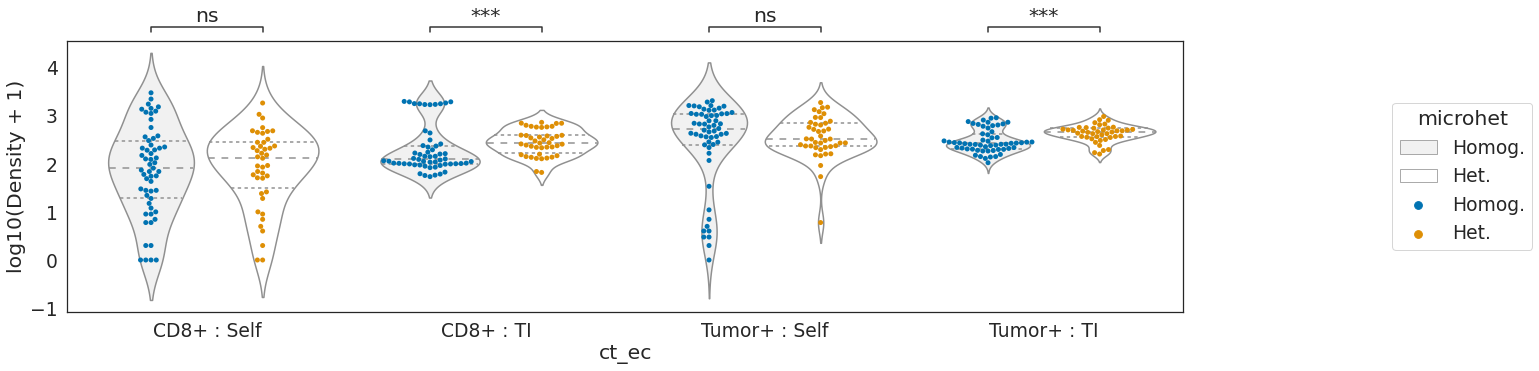



 Remove IP_19_K00367
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CD8+ : TI_Homog. vs. CD8+ : TI_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:1.259e-08 U_stat=2.940e+02
CD8+ : Self_Homog. vs. CD8+ : Self_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:3.570e-02 U_stat=7.310e+02
Tumor+ : Self_Homog. vs. Tumor+ : Self_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:7.414e-04 U_stat=1.398e+03
Tumor+ : TI_Homog. vs. Tumor+ : TI_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:7.481e-08 U_stat=3.320e+02


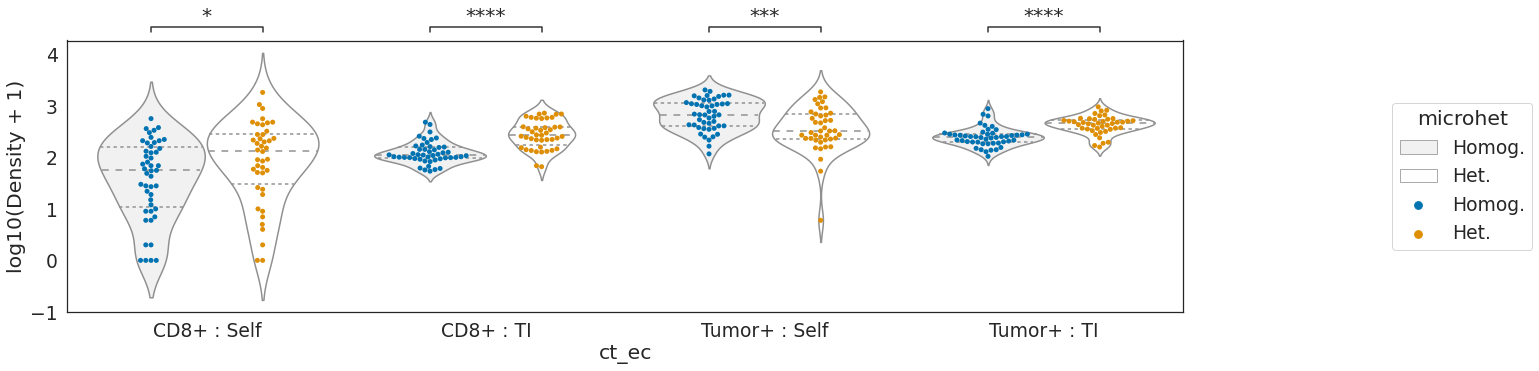



 Remove IP_19_K00367 and LN
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CD8+ : TI_Homog. vs. CD8+ : TI_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:9.140e-04 U_stat=2.590e+02
CD8+ : Self_Homog. vs. CD8+ : Self_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:6.382e-01 U_stat=4.800e+02
Tumor+ : Self_Homog. vs. Tumor+ : Self_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:8.418e-01 U_stat=5.330e+02
Tumor+ : TI_Homog. vs. Tumor+ : TI_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:7.926e-05 U_stat=2.100e+02


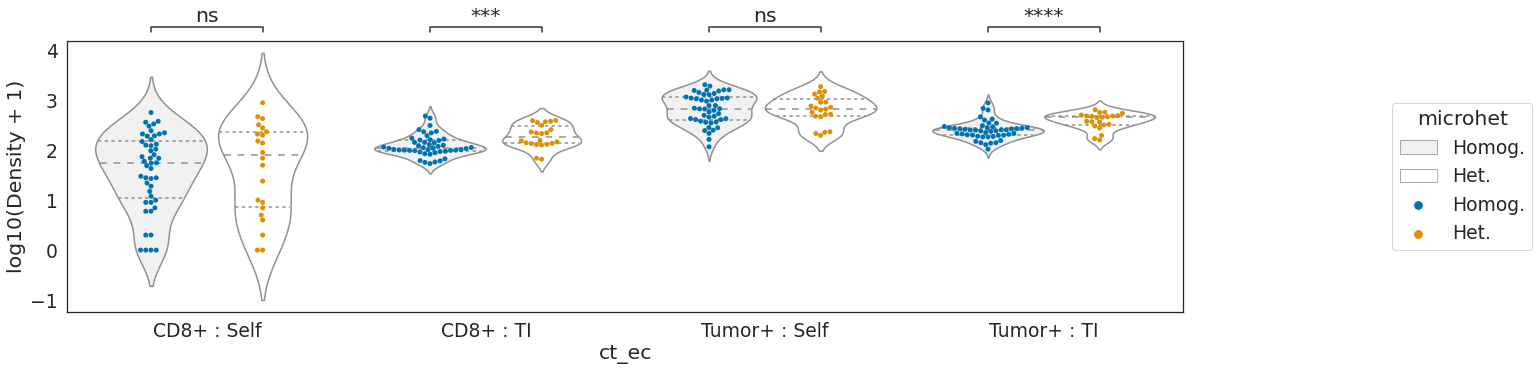

In [237]:
plot_marginals = False
fit_intercept = True
tmp_sweep = sweep_exclusions_hardcode(ct_ec_counts)
for k, filtered_df in tmp_sweep.items():
    print(f'\n\n ====== \n {k}')
    
    for y in ['log10(Density + 1)']:
        plot_kws = {
            'order':None,
            'y':y,
            'x':'ct_ec',
            'order':np.sort(filtered_df['ct_ec'].unique()),
            'hue':'microhet',
            'hue_order':MH_ORDER,
            'data':filtered_df,
        }

        i = plot_kws['data'][plot_kws['x']].unique()
        j = plot_kws['data'][plot_kws['hue']].unique()

        set_rc(int(5*len(i)),5, 1.7 )

        pairs = make_statannotations_pairs(i,j,'inner')

        g = sns.violinplot(**plot_kws, inner='quartile',  color='white')
        annotator = Annotator(g, pairs, **plot_kws)
        annotator.configure(test=TEST, text_format= TEXT_FORMAT, loc='outside')
        annotator.apply_and_annotate()


        g = sns.swarmplot(**plot_kws,dodge=True, )
        move_legend(g, xy=(1.25, 0.5))
        f = f'./figures/density_in_base_ct__({k})'
        flex_save(f, dpi=400)
        plt.show()
        
        unpacked_pvals = unpack_annotator(annotator)
        pval_str = f'[Supp] [({annotator.test} {annotator.text_format})] density_in_base_ct__(({k})'
        scattered_results[pval_str] = unpacked_pvals
        
        median_str = f'[Supp] [MH Medians] density_in_base_ct__({k})'
        median_val = plot_kws['data'].groupby([plot_kws['x'], 'microhet'])[plot_kws['y']].median()
        scattered_results[median_str] = median_val

In [238]:

# plot_marginals = False
# fit_intercept = True
# tmp_sweep = sweep_exclusions_hardcode(ct_ec_counts)
# for k, filtered_df in tmp_sweep.items():
#     print(f'\n\n ====== \n {k}')
    
#     reduced = filtered_df.groupby(['case_id','microhet','ct_ec']).median().reset_index()
#     add_log10_density(reduced, 'Density')
    
#     for y in ['log10(Density + 1)']:
#         plot_kws = {
#             'order':None,
#             'y':y,
#             'x':'ct_ec',
#             'order':np.sort(reduced['ct_ec'].unique()),
#             'hue':'microhet',
#             'hue_order':MH_ORDER,
#             'data':reduced,
#         }

#         i = plot_kws['data'][plot_kws['x']].unique()
#         j = plot_kws['data'][plot_kws['hue']].unique()

#         set_rc(int(5*len(i)),5, 1.7 )

#         pairs = make_statannotations_pairs(i,j,'inner')

#         g = sns.violinplot(**plot_kws, inner='quartile',  color='white')
#         annotator = Annotator(g, pairs, **plot_kws)
#         annotator.configure(test=TEST, text_format= TEXT_FORMAT, loc='outside')
#         annotator.apply_and_annotate()


#         g = sns.swarmplot(**plot_kws,dodge=True, )
#         move_legend(g, xy=(1.25, 0.5))
#         f = f'./figures/mean_density_in_base_ct__({k})'
#         flex_save(f, dpi=400)
#         plt.show()

### Frequency of TI in base CT

In [239]:
ref_total_density = ct_counts.set_index(['case_id','px','py','cell_type'])['Density']
ref_total_density.name = 'Total Density'

plot_data = ct_ec_counts.set_index(['case_id','px','py','cell_type']).join(ref_total_density).reset_index()
plot_data['Density Fraction'] = plot_data['Density']/plot_data['Total Density']
plot_data['Frequency'] = plot_data['Density Fraction']

plot_data.to_csv('./ct_ec_immune_hotspot_counts.csv')



 base
medians 
 ct_ec        microhet
CD8+ : TI    Het.        0.736974
             Homog.      0.609626
Tumor+ : TI  Het.        0.570522
             Homog.      0.318124
Name: Frequency, dtype: float64
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Tumor+ : TI_Homog. vs. Tumor+ : TI_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:2.147e-03 U_stat=7.630e+02
CD8+ : TI_Homog. vs. CD8+ : TI_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:4.175e-01 U_stat=1.082e+03


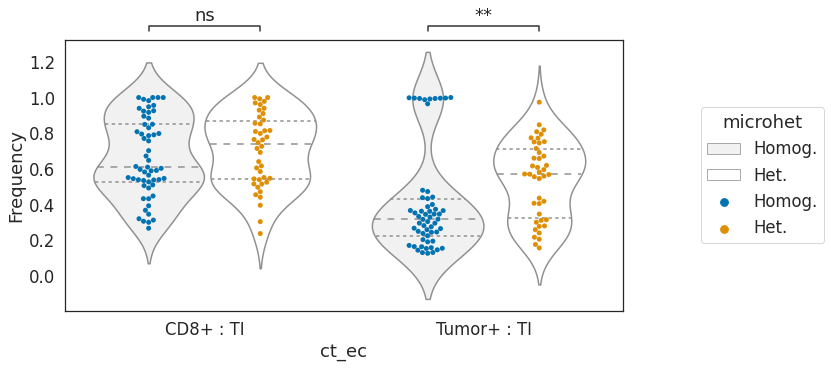



 Remove IP_19_K00367
medians 
 ct_ec        microhet
CD8+ : TI    Het.        0.736974
             Homog.      0.756757
Tumor+ : TI  Het.        0.570522
             Homog.      0.281915
Name: Frequency, dtype: float64
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Tumor+ : TI_Homog. vs. Tumor+ : TI_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:1.289e-07 U_stat=3.440e+02
CD8+ : TI_Homog. vs. CD8+ : TI_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:8.468e-01 U_stat=9.630e+02


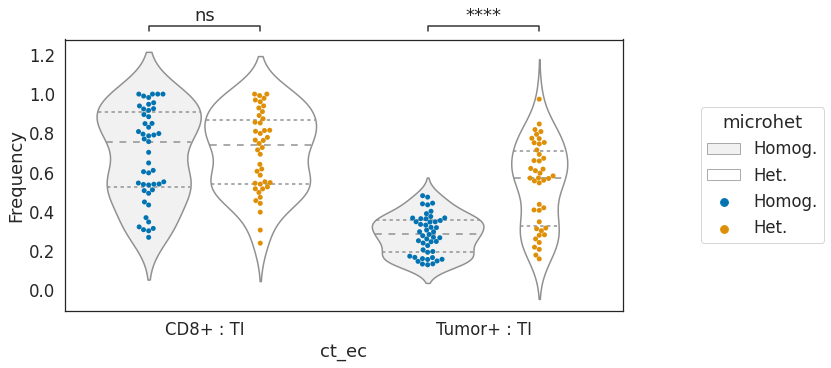



 Remove IP_19_K00367 and LN
medians 
 ct_ec        microhet
CD8+ : TI    Het.        0.719780
             Homog.      0.756757
Tumor+ : TI  Het.        0.330642
             Homog.      0.281915
Name: Frequency, dtype: float64
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Tumor+ : TI_Homog. vs. Tumor+ : TI_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:2.634e-02 U_stat=3.440e+02
CD8+ : TI_Homog. vs. CD8+ : TI_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:6.661e-01 U_stat=4.830e+02


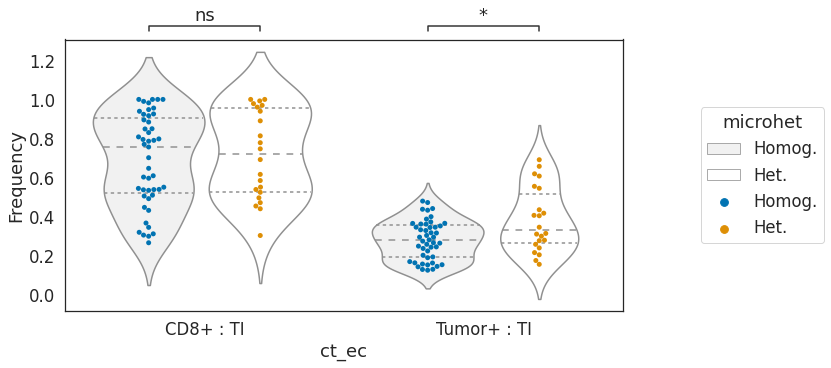

In [240]:
mode='inner'
tmp_sweep = sweep_exclusions_hardcode(plot_data.loc[plot_data['self'] == 'TI'])
for k, filtered_df in tmp_sweep.items():
    print(f'\n\n ====== \n {k}')
    
    plot_kws = {
        'order':None,
        'y':'Frequency',
        'x':'ct_ec',
        'order': None,
        'hue':'microhet',
        'hue_order':MH_ORDER,
        'data':filtered_df,
    }
    
    print('medians \n', filtered_df.groupby(['ct_ec','microhet'])['Frequency'].median())
    
    i = plot_kws['data'][plot_kws['x']].unique()
    j = plot_kws['data'][plot_kws['hue']].unique()

    set_rc(int(5*len(i)),5, 1.5 )

    pairs = make_statannotations_pairs(i,j,mode)

    g = sns.violinplot(**plot_kws, inner='quartile',  color='white',)
    annotator = Annotator(g, pairs, **plot_kws)
    annotator.configure(test=TEST, text_format= TEXT_FORMAT, loc='outside')
    annotator.apply_and_annotate()


    g = sns.swarmplot(**plot_kws,dodge=True, )
    move_legend(g, xy=(1.25, 0.5))
    f = f'./figures/frequency_ti_in_base_ct__({k})'
    flex_save(f, dpi=400)
    plt.show()
    
    unpacked_pvals = unpack_annotator(annotator)
    pval_str = f'[Supp] [({annotator.test} {annotator.text_format})] frequency_ti_in_base_ct__({k})'
    scattered_results[pval_str] = unpacked_pvals
    
    median_str = f'[Supp] [MH Medians] frequency_ti_in_base_ct__({k})'
    median_val = plot_kws['data'].groupby([plot_kws['x'], 'microhet'])[plot_kws['y']].median()
    scattered_results[median_str] = median_val

### Frequency of PDL1-High in general Tumor+

In [241]:
dct_counts['cell_type'] = dct_counts['detailed_cell_type'].apply(lambda x: x.split(' ')[0])

In [242]:
mode = 'inner'

ref_density = dct_counts.loc[dct_counts['detailed_cell_type'].str.startswith('Tumor+')].groupby(['case_id','microhet','biopsySite','px','py','cell_type',])['Density'].sum().reset_index()
ref_density = ref_density.set_index(['case_id','px','py','cell_type'])['Density']
ref_density.name = 'Total Density'


plot_data = dct_counts.loc[dct_counts['detailed_cell_type'].str.startswith('Tumor+')]
plot_data = plot_data.set_index(['case_id','px','py','cell_type']).join(ref_density).reset_index()
plot_data['Density Fraction'] = plot_data['Density']/plot_data['Total Density']
plot_data['Frequency'] = plot_data['Density Fraction']
plot_data['DCC'] = plot_data['detailed_cell_type']


In [243]:
res = '[Supp] Frequency of PDL1 High (Mean)'
scattered_results[res] = plot_data.loc[plot_data['detailed_cell_type'] == 'Tumor+ PDL1 High']['Density Fraction'].mean()
print(res, scattered_results[res])

res = '[Supp] Frequency of PDL1 High (Median)'
scattered_results[res] = plot_data.loc[plot_data['detailed_cell_type'] == 'Tumor+ PDL1 High']['Density Fraction'].median()
print(res, scattered_results[res])

[Supp] Frequency of PDL1 High (Mean) 0.17781427220555454
[Supp] Frequency of PDL1 High (Median) 0.15


### Frequency of PD1-High in general CD8+

In [244]:
mode = 'inner'

ref_density = dct_counts.loc[dct_counts['detailed_cell_type'].str.startswith('CD8+')].groupby(['case_id','microhet','biopsySite','px','py','cell_type',])['Density'].sum().reset_index()
ref_density = ref_density.set_index(['case_id','px','py','cell_type'])['Density']
ref_density.name = 'Total Density'


plot_data = dct_counts.loc[dct_counts['detailed_cell_type'].str.startswith('CD8+')]
plot_data = plot_data.set_index(['case_id','px','py','cell_type']).join(ref_density).reset_index()
plot_data['Density Fraction'] = plot_data['Density']/plot_data['Total Density']
plot_data['Frequency'] = plot_data['Density Fraction']
plot_data['DCC'] = plot_data['detailed_cell_type']


In [245]:
res = '[Supp] Frequency of PD1 High (Mean)'
scattered_results[res] = plot_data.loc[plot_data['detailed_cell_type'] == 'CD8+ PD1 High']['Density Fraction'].mean()
print(res, scattered_results[res])

res = '[Supp] Frequency of PD1 High (Median)'
scattered_results[res] = plot_data.loc[plot_data['detailed_cell_type'] == 'CD8+ PD1 High']['Density Fraction'].median()
print(res, scattered_results[res])

[Supp] Frequency of PD1 High (Mean) 0.4636725183694559
[Supp] Frequency of PD1 High (Median) 0.48031496062992124


In [246]:
plot_data.loc[plot_data['detailed_cell_type'] == 'CD8+ PD1 High'].groupby('microhet')['Density Fraction'].median()

microhet
Het.      0.554718
Homog.    0.426357
Name: Density Fraction, dtype: float64

### Frequency of PD1 high in Tumor+TI



 base
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Tumor+ : CD8+ PD1 High_Homog. vs. Tumor+ : CD8+ PD1 High_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:1.136e-01 U_stat=9.730e+02


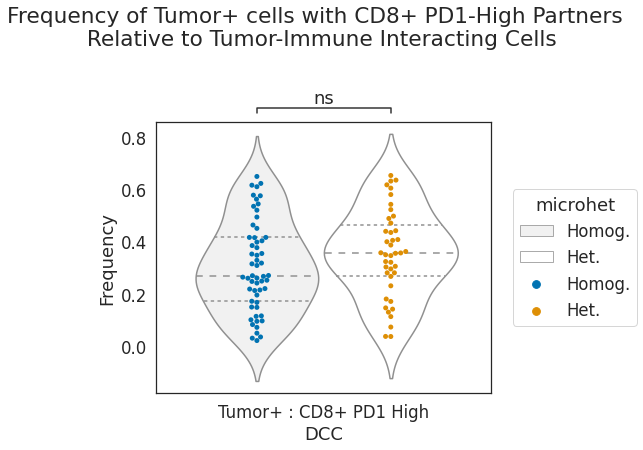



 Remove IP_19_K00367
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Tumor+ : CD8+ PD1 High_Homog. vs. Tumor+ : CD8+ PD1 High_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:6.963e-01 U_stat=9.390e+02


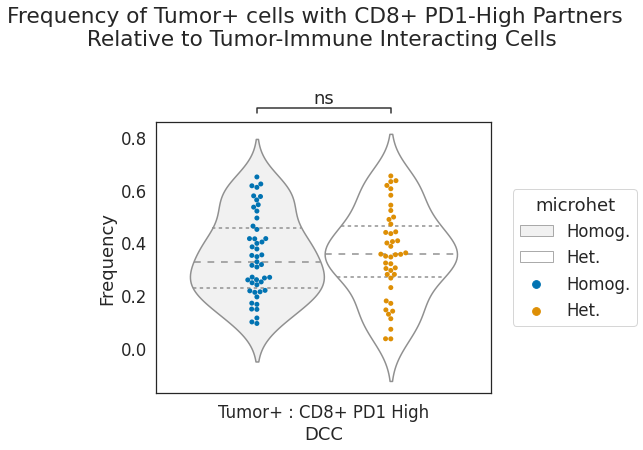



 Remove IP_19_K00367 and LN
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Tumor+ : CD8+ PD1 High_Homog. vs. Tumor+ : CD8+ PD1 High_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:9.333e-01 U_stat=5.100e+02


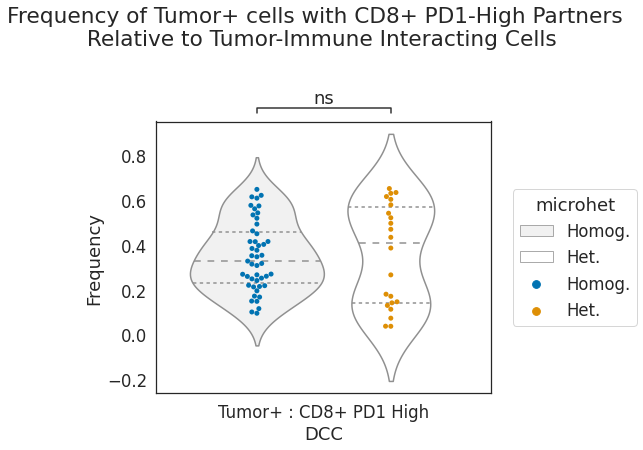

In [250]:
mode = 'inner'

ref_ti_density = dcc_counts.loc[dcc_counts['self'] == 'TI'].groupby(['case_id','microhet','biopsySite','px','py','cell_type',])['Density'].sum().reset_index()
ref_ti_density = ref_ti_density.set_index(['case_id','px','py','cell_type'])['Density']
ref_ti_density.name = 'Total Density'


plot_data = collapsed_tumor_counts.loc[(collapsed_tumor_counts['cell_type'] == 'Tumor+') & (collapsed_tumor_counts['self'] == 'TI')]
plot_data = plot_data.set_index(['case_id','px','py','cell_type']).join(ref_ti_density).reset_index()
plot_data['Density Fraction'] = plot_data['Density']/plot_data['Total Density']
plot_data['Frequency'] = plot_data['Density Fraction']
plot_data['DCC'] = plot_data['collapsed_tumor_cell_type'].astype(str) + ' : ' + plot_data['partner']

tmp_sweep = sweep_exclusions_hardcode(plot_data.loc[(plot_data['self'] == 'TI') & (plot_data['cell_type'] == 'Tumor+')])
for k, filtered_df in tmp_sweep.items():
    print(f'\n\n ====== \n {k}')
    
    plot_kws = {
        'order':None,
        'y':'Frequency',
        'x':'DCC',
        'order': None,
        'hue':'microhet',
        'hue_order':MH_ORDER,
        'data':filtered_df.loc[filtered_df['DCC'] == 'Tumor+ : CD8+ PD1 High'],
    }

    i = plot_kws['data'][plot_kws['x']].unique()
    j = plot_kws['data'][plot_kws['hue']].unique()

    set_rc(int(6*len(i)),5, 1.5 )

    pairs = make_statannotations_pairs(i,j,mode)

    g = sns.violinplot(**plot_kws, inner='quartile',  color='white',)
    annotator = Annotator(g, pairs, **plot_kws)
    annotator.configure(test=TEST, text_format= TEXT_FORMAT, loc='outside')
    annotator.apply_and_annotate()


    g = sns.swarmplot(**plot_kws,dodge=True, )
    move_legend(g, xy=(1.25, 0.5))
    title_str = 'Frequency of Tumor+ cells with CD8+ PD1-High Partners \n Relative to Tumor-Immune Interacting Cells'
    plt.suptitle(title_str, y=1.2)
    title_str = title_str.replace('\n','')
    f = f'./figures/{title_str}__({k})'
    flex_save(f, dpi=400)
    plt.show()
    
    unpacked_pvals = unpack_annotator(annotator)
    pval_str = f'[Supp] [({annotator.test} {annotator.text_format})] {title_str}__({k})'
    scattered_results[pval_str] = unpacked_pvals
    
    median_str = f'[Supp] [MH Medians] {title_str}__({k})'
    median_val = plot_kws['data'].groupby('microhet')[plot_kws['y']].median()
    scattered_results[median_str] = median_val


### Frequency of PD1 high in CD8+TI



 base
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CD8+ PD1 High : Tumor+_Homog. vs. CD8+ PD1 High : Tumor+_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:9.082e-03 U_stat=8.280e+02


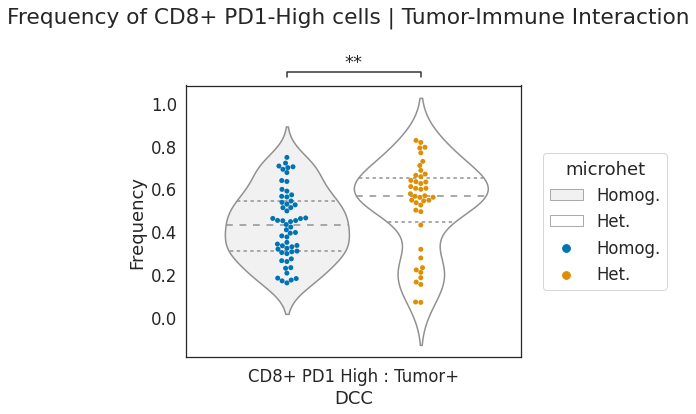



 Remove IP_19_K00367
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CD8+ PD1 High : Tumor+_Homog. vs. CD8+ PD1 High : Tumor+_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:9.745e-03 U_stat=6.720e+02


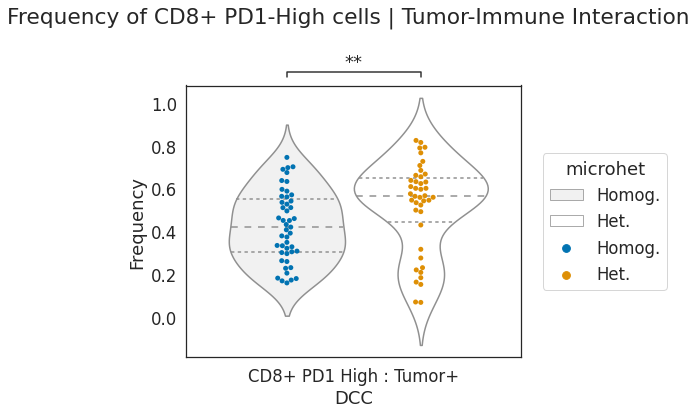



 Remove IP_19_K00367 and LN
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CD8+ PD1 High : Tumor+_Homog. vs. CD8+ PD1 High : Tumor+_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:4.360e-01 U_stat=4.560e+02


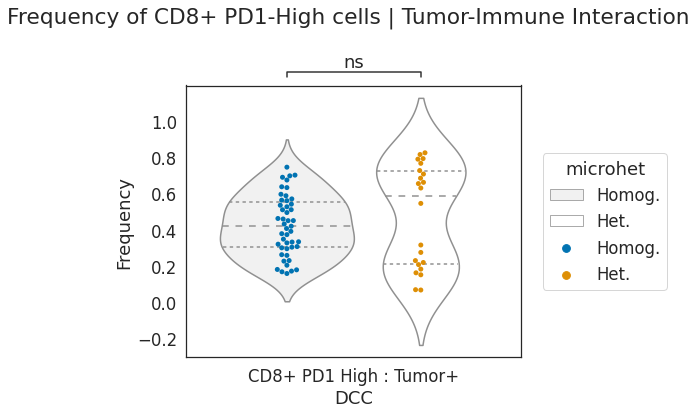

In [251]:
mode = 'inner'

ref_ti_density = dcc_counts.loc[dcc_counts['self'] == 'TI'].groupby(['case_id','microhet','biopsySite','px','py','cell_type',])['Density'].sum().reset_index()
ref_ti_density = ref_ti_density.set_index(['case_id','px','py','cell_type'])['Density']
ref_ti_density.name = 'Total Density'


plot_data = collapsed_tumor_counts.loc[(collapsed_tumor_counts['cell_type'] == 'CD8+') & (collapsed_tumor_counts['self'] == 'TI')]
plot_data = plot_data.set_index(['case_id','px','py','cell_type']).join(ref_ti_density).reset_index()
plot_data['Density Fraction'] = plot_data['Density']/plot_data['Total Density']
plot_data['Frequency'] = plot_data['Density Fraction']
plot_data['DCC'] = plot_data['collapsed_tumor_cell_type'].astype(str) + ' : ' + plot_data['partner']

tmp_sweep = sweep_exclusions_hardcode(plot_data.loc[(plot_data['self'] == 'TI') & (plot_data['cell_type'] == 'CD8+')])
for k, filtered_df in tmp_sweep.items():
    print(f'\n\n ====== \n {k}')
    
    plot_kws = {
        'order':None,
        'y':'Frequency',
        'x':'DCC',
        'order': None,
        'hue':'microhet',
        'hue_order':MH_ORDER,
        'data':filtered_df.loc[filtered_df['DCC'] == 'CD8+ PD1 High : Tumor+'],
    }

    i = plot_kws['data'][plot_kws['x']].unique()
    j = plot_kws['data'][plot_kws['hue']].unique()

    set_rc(int(6*len(i)),5, 1.5 )

    pairs = make_statannotations_pairs(i,j,mode)

    g = sns.violinplot(**plot_kws, inner='quartile',  color='white',)
    annotator = Annotator(g, pairs, **plot_kws)
    annotator.configure(test=TEST, text_format= TEXT_FORMAT, loc='outside')
    annotator.apply_and_annotate()


    g = sns.swarmplot(**plot_kws,dodge=True, )
    move_legend(g, xy=(1.25, 0.5))
    title_str = 'Frequency of CD8+ PD1-High cells | Tumor-Immune Interaction'
    plt.suptitle(title_str, y=1.1)
    title_str = title_str.replace('\n','')
    f = f'./figures/{title_str}__({k})'
    flex_save(f, dpi=400)
    plt.show()
    
    unpacked_pvals = unpack_annotator(annotator)
    pval_str = f'[Supp] [({annotator.test} {annotator.text_format})] {title_str}__({k})'
    scattered_results[pval_str] = unpacked_pvals
    
    median_str = f'[Supp] [MH Medians] {title_str}__({k})'
    median_val = plot_kws['data'].groupby('microhet')[plot_kws['y']].median()
    scattered_results[median_str] = median_val


### Frequency of PD1 high in T+ PDL1 High



 base
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Tumor+ PDL1 High : CD8+ PD1 High_Homog. vs. Tumor+ PDL1 High : CD8+ PD1 High_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:5.905e-01 U_stat=1.120e+03


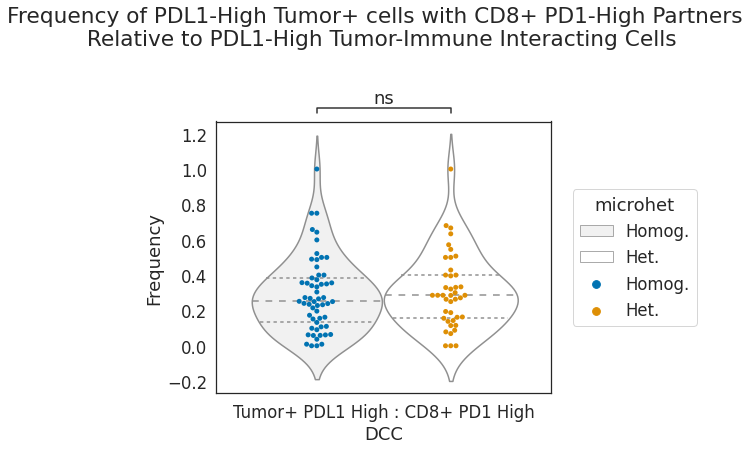



 Remove IP_19_K00367
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Tumor+ PDL1 High : CD8+ PD1 High_Homog. vs. Tumor+ PDL1 High : CD8+ PD1 High_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:5.567e-01 U_stat=1.059e+03


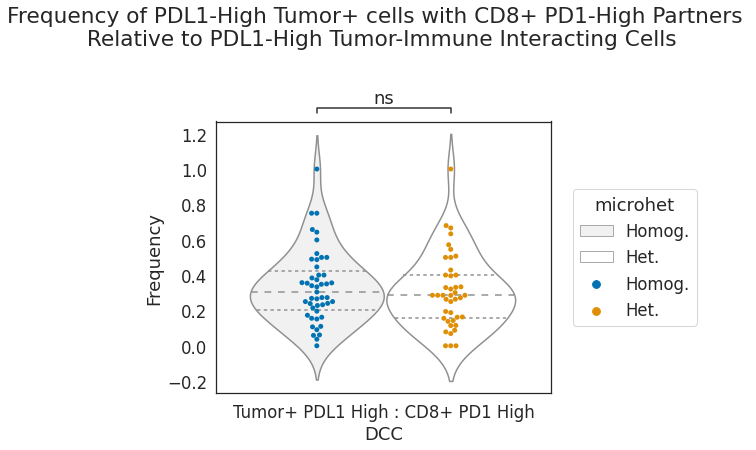



 Remove IP_19_K00367 and LN
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Tumor+ PDL1 High : CD8+ PD1 High_Homog. vs. Tumor+ PDL1 High : CD8+ PD1 High_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:1.510e-01 U_stat=6.290e+02


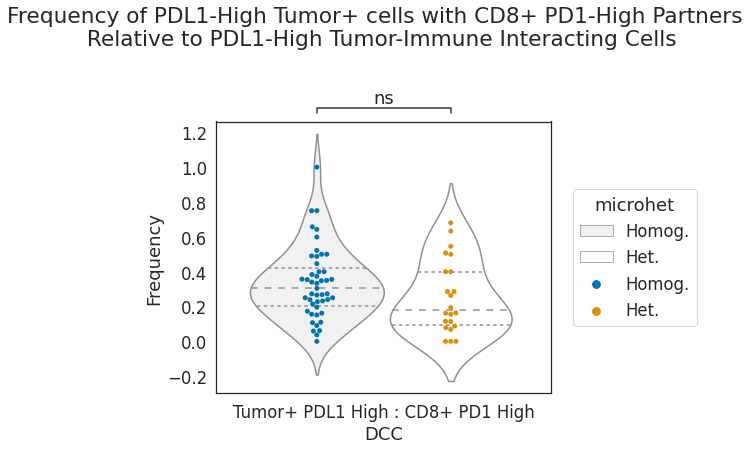

In [252]:
mode = 'inner'

crit = (dcc_counts['self'] == 'TI') & (dcc_counts['detailed_cell_type'] == 'Tumor+ PDL1 High')
ref_ti_density = dcc_counts.loc[crit].groupby(['case_id','microhet','biopsySite','px','py','cell_type',])['Density'].sum().reset_index()
ref_ti_density = ref_ti_density.set_index(['case_id','px','py','cell_type'])['Density']
ref_ti_density.name = 'Total Density'


plot_data = dcc_counts.loc[crit]
plot_data = plot_data.set_index(['case_id','px','py','cell_type']).join(ref_ti_density).reset_index()
plot_data['Density Fraction'] = plot_data['Density']/plot_data['Total Density']
plot_data['Frequency'] = plot_data['Density Fraction']
plot_data['DCC'] = plot_data['detailed_cell_context'].astype(str)

tmp_sweep = sweep_exclusions_hardcode(plot_data)
for k, filtered_df in tmp_sweep.items():
    print(f'\n\n ====== \n {k}')
    
    plot_kws = {
        'order':None,
        'y':'Frequency',
        'x':'DCC',
        'order': None,
        'hue':'microhet',
        'hue_order':MH_ORDER,
        'data':filtered_df.loc[filtered_df['DCC'] == 'Tumor+ PDL1 High : CD8+ PD1 High'],
    }

    i = plot_kws['data'][plot_kws['x']].unique()
    j = plot_kws['data'][plot_kws['hue']].unique()

    set_rc(int(6*len(i)),5, 1.5 )

    pairs = make_statannotations_pairs(i,j,mode)

    g = sns.violinplot(**plot_kws, inner='quartile',  color='white',)
    annotator = Annotator(g, pairs, **plot_kws)
    annotator.configure(test=TEST, text_format= TEXT_FORMAT, loc='outside')
    annotator.apply_and_annotate()


    g = sns.swarmplot(**plot_kws,dodge=True, )
    move_legend(g, xy=(1.25, 0.5))
    title_str = 'Frequency of PDL1-High Tumor+ cells with CD8+ PD1-High Partners \n Relative to PDL1-High Tumor-Immune Interacting Cells'
    plt.suptitle(title_str, y=1.2)
    title_str = title_str.replace('\n','')
    f = f'./figures/{title_str}__({k})'
    flex_save(f, dpi=400)
    plt.show()
    
    unpacked_pvals = unpack_annotator(annotator)
    pval_str = f'[Supp] [({annotator.test} {annotator.text_format})] {title_str}__({k})'
    scattered_results[pval_str] = unpacked_pvals
    
    
    median_str = f'[Supp] [MH Medians] {title_str}__({k})'
    median_val = plot_kws['data'].groupby('microhet')[plot_kws['y']].median()
    scattered_results[median_str] = median_val


### Frequency of PD1 high in T+ PDL1 Low



 base
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Tumor+ PDL1 Low : CD8+ PD1 High_Homog. vs. Tumor+ PDL1 Low : CD8+ PD1 High_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:1.325e-01 U_stat=9.840e+02


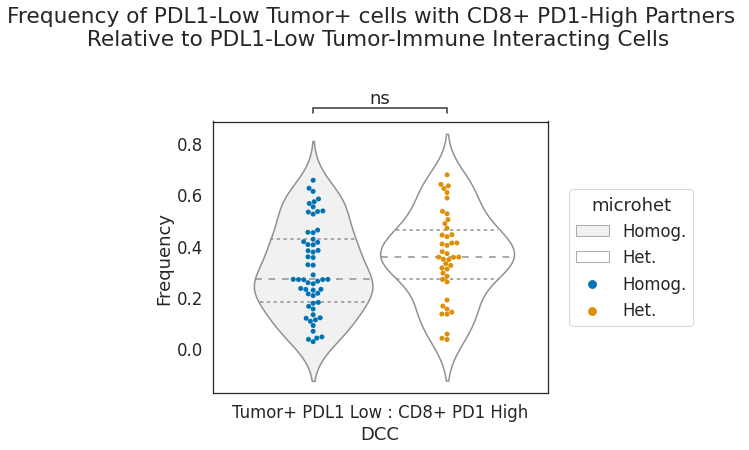



 Remove IP_19_K00367
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Tumor+ PDL1 Low : CD8+ PD1 High_Homog. vs. Tumor+ PDL1 Low : CD8+ PD1 High_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:7.455e-01 U_stat=9.470e+02


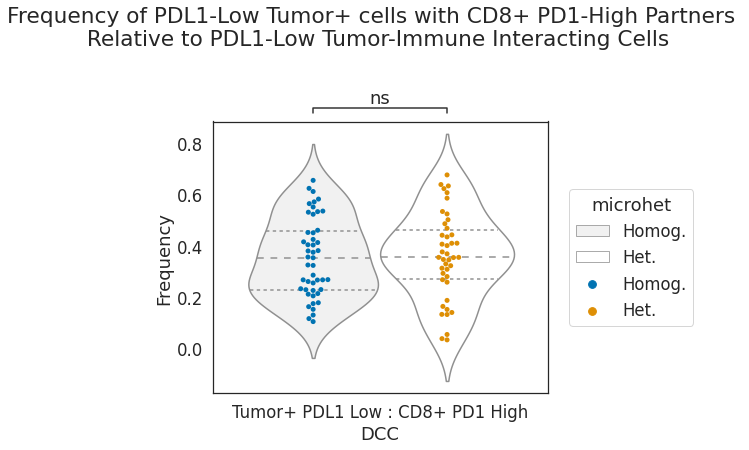



 Remove IP_19_K00367 and LN
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Tumor+ PDL1 Low : CD8+ PD1 High_Homog. vs. Tumor+ PDL1 Low : CD8+ PD1 High_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:9.128e-01 U_stat=5.080e+02


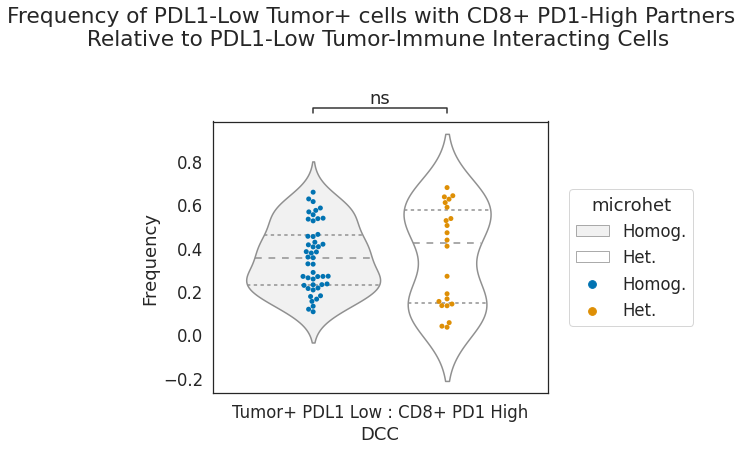

In [253]:
mode = 'inner'

crit = (dcc_counts['self'] == 'TI') & (dcc_counts['detailed_cell_type'] == 'Tumor+ PDL1 Low')
ref_ti_density = dcc_counts.loc[crit].groupby(['case_id','microhet','biopsySite','px','py','cell_type',])['Density'].sum().reset_index()
ref_ti_density = ref_ti_density.set_index(['case_id','px','py','cell_type'])['Density']
ref_ti_density.name = 'Total Density'


plot_data = dcc_counts.loc[crit]
plot_data = plot_data.set_index(['case_id','px','py','cell_type']).join(ref_ti_density).reset_index()
plot_data['Density Fraction'] = plot_data['Density']/plot_data['Total Density']
plot_data['Frequency'] = plot_data['Density Fraction']
plot_data['DCC'] = plot_data['detailed_cell_context'].astype(str)

tmp_sweep = sweep_exclusions_hardcode(plot_data)
for k, filtered_df in tmp_sweep.items():
    print(f'\n\n ====== \n {k}')
    
    plot_kws = {
        'order':None,
        'y':'Frequency',
        'x':'DCC',
        'order': None,
        'hue':'microhet',
        'hue_order':MH_ORDER,
        'data':filtered_df.loc[filtered_df['DCC'] == 'Tumor+ PDL1 Low : CD8+ PD1 High'],
    }

    i = plot_kws['data'][plot_kws['x']].unique()
    j = plot_kws['data'][plot_kws['hue']].unique()

    set_rc(int(6*len(i)),5, 1.5 )

    pairs = make_statannotations_pairs(i,j,mode)

    g = sns.violinplot(**plot_kws, inner='quartile',  color='white',)
    annotator = Annotator(g, pairs, **plot_kws)
    annotator.configure(test=TEST, text_format= TEXT_FORMAT, loc='outside')
    annotator.apply_and_annotate()


    g = sns.swarmplot(**plot_kws,dodge=True, )
    move_legend(g, xy=(1.25, 0.5))
    title_str = 'Frequency of PDL1-Low Tumor+ cells with CD8+ PD1-High Partners \n Relative to PDL1-Low Tumor-Immune Interacting Cells'
    plt.suptitle(title_str, y=1.2)
    title_str = title_str.replace('\n','')
    f = f'./figures/{title_str}__({k})'
    flex_save(f, dpi=400)
    plt.show()
    
    unpacked_pvals = unpack_annotator(annotator)
    pval_str = f'[Supp] [({annotator.test} {annotator.text_format})] {title_str}__({k})'
    scattered_results[pval_str] = unpacked_pvals
    
    median_str = f'[Supp] [MH Medians] {title_str}__({k})'
    median_val = plot_kws['data'].groupby('microhet')[plot_kws['y']].median()
    scattered_results[median_str] = median_val


### Frequency of PD1 high in CD8+ interacting with T+ PDL1 High



 base
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CD8+ PD1 High : Tumor+ PDL1 High_Homog. vs. CD8+ PD1 High : Tumor+ PDL1 High_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:1.338e-01 U_stat=7.895e+02


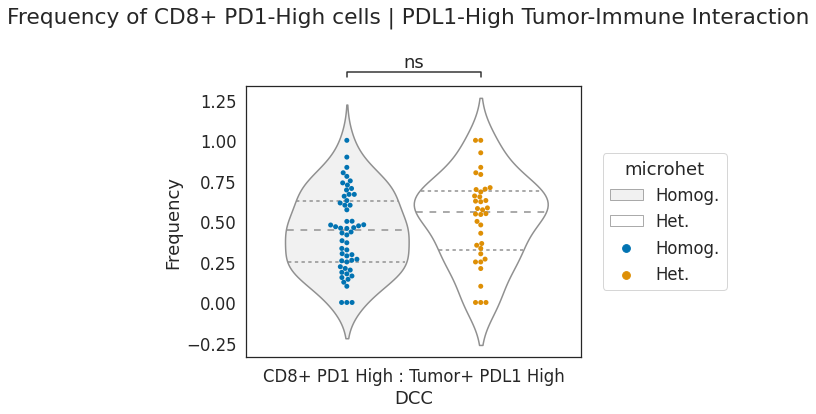



 Remove IP_19_K00367
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CD8+ PD1 High : Tumor+ PDL1 High_Homog. vs. CD8+ PD1 High : Tumor+ PDL1 High_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:1.495e-01 U_stat=6.425e+02


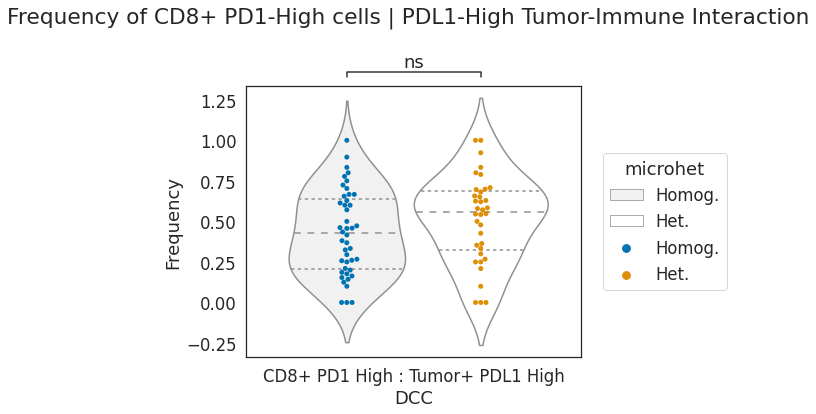



 Remove IP_19_K00367 and LN
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CD8+ PD1 High : Tumor+ PDL1 High_Homog. vs. CD8+ PD1 High : Tumor+ PDL1 High_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:8.436e-01 U_stat=4.690e+02


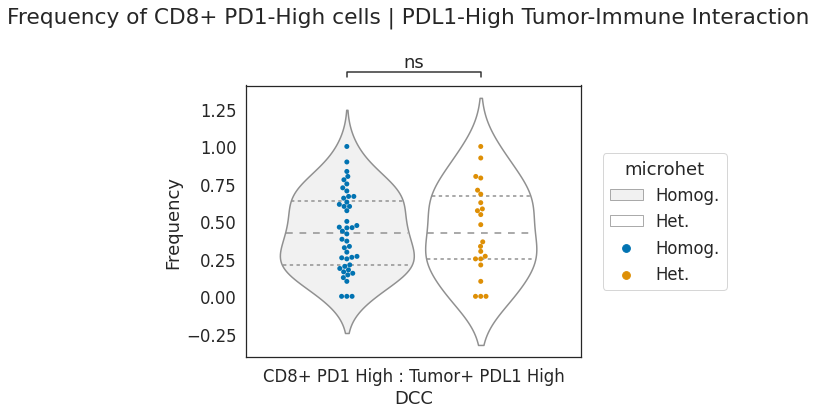

In [254]:
mode = 'inner'

crit = (dcc_counts['self'] == 'TI') & (dcc_counts['partner'] == 'Tumor+ PDL1 High')
ref_ti_density = dcc_counts.loc[crit].groupby(['case_id','microhet','biopsySite','px','py','cell_type',])['Density'].sum().reset_index()
ref_ti_density = ref_ti_density.set_index(['case_id','px','py','cell_type'])['Density']
ref_ti_density.name = 'Total Density'


plot_data = dcc_counts.loc[crit]
plot_data = plot_data.set_index(['case_id','px','py','cell_type']).join(ref_ti_density).reset_index()
plot_data['Density Fraction'] = plot_data['Density']/plot_data['Total Density']
plot_data['Frequency'] = plot_data['Density Fraction']
plot_data['DCC'] = plot_data['detailed_cell_context'].astype(str)

tmp_sweep = sweep_exclusions_hardcode(plot_data)
for k, filtered_df in tmp_sweep.items():
    print(f'\n\n ====== \n {k}')
    
    plot_kws = {
        'order':None,
        'y':'Frequency',
        'x':'DCC',
        'order': None,
        'hue':'microhet',
        'hue_order':MH_ORDER,
        'data':filtered_df.loc[filtered_df['DCC'] == 'CD8+ PD1 High : Tumor+ PDL1 High'],
    }

    i = plot_kws['data'][plot_kws['x']].unique()
    j = plot_kws['data'][plot_kws['hue']].unique()

    set_rc(int(6*len(i)),5, 1.5 )

    pairs = make_statannotations_pairs(i,j,mode)

    g = sns.violinplot(**plot_kws, inner='quartile',  color='white',)
    annotator = Annotator(g, pairs, **plot_kws)
    annotator.configure(test=TEST, text_format= TEXT_FORMAT, loc='outside')
    annotator.apply_and_annotate()


    g = sns.swarmplot(**plot_kws,dodge=True, )
    move_legend(g, xy=(1.25, 0.5))
    title_str = 'Frequency of CD8+ PD1-High cells | PDL1-High Tumor-Immune Interaction'
    plt.suptitle(title_str, y=1.1)
    title_str = title_str.replace('\n','')
    f = f'./figures/{title_str}__({k})'
    flex_save(f, dpi=400)
    plt.show()
    
    unpacked_pvals = unpack_annotator(annotator)
    pval_str = f'[Supp] [({annotator.test} {annotator.text_format})] {title_str}__({k})'
    scattered_results[pval_str] = unpacked_pvals
    
    median_str = f'[Supp] [MH Medians] {title_str}__({k})'
    median_val = plot_kws['data'].groupby('microhet')[plot_kws['y']].median()
    scattered_results[median_str] = median_val

In [255]:
plot_data.groupby(['detailed_cell_context'])['Density'].describe().dropna()

,count,mean,std,min,25%,50%,75%,max
detailed_cell_context,,,,,,,,
CD8+ PD1 High : Tumor+ PDL1 High,99.0,34.434343,60.232401,0.0,2.0,8.0,29.5,312.0
CD8+ PD1 Low : Tumor+ PDL1 High,99.0,36.484848,54.756113,0.0,2.5,10.0,53.5,207.0


(array([41.,  6.,  4., 11.,  2.,  5.,  4.,  4.,  2., 11.]),
 array([3.41079455e-23, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

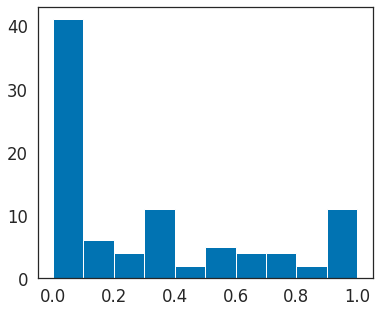

In [256]:
from scipy.stats import binomtest

pvals = []
for idx, d in plot_data.groupby(['case_id','px','py']):
    try:
        tmp = d.loc[d['detailed_cell_context'] == 'CD8+ PD1 High : Tumor+ PDL1 High']
        pval = binomtest(tmp['Density'].item(), tmp['Total Density'].item()).pvalue
        pvals.append(pval)
    except:
        pass

plt.hist(np.array(pvals))

In [257]:
(np.array(pvals) < 0.05).mean()

0.3888888888888889

### Frequency of PD1 high in CD8+ interacting with T+ PDL1 Low



 base
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CD8+ PD1 High : Tumor+ PDL1 Low_Homog. vs. CD8+ PD1 High : Tumor+ PDL1 Low_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:6.987e-03 U_stat=8.155e+02


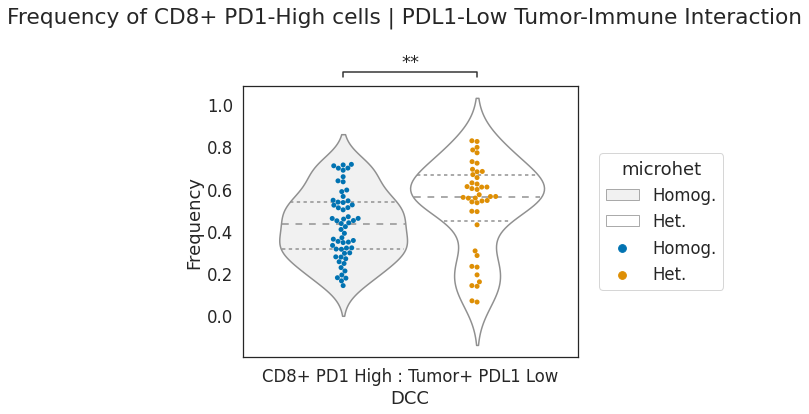



 Remove IP_19_K00367
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CD8+ PD1 High : Tumor+ PDL1 Low_Homog. vs. CD8+ PD1 High : Tumor+ PDL1 Low_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:7.378e-03 U_stat=6.605e+02


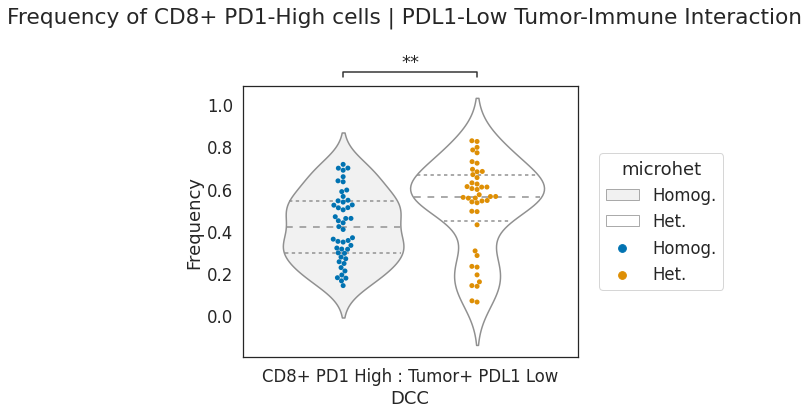



 Remove IP_19_K00367 and LN
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CD8+ PD1 High : Tumor+ PDL1 Low_Homog. vs. CD8+ PD1 High : Tumor+ PDL1 Low_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:4.247e-01 U_stat=4.545e+02


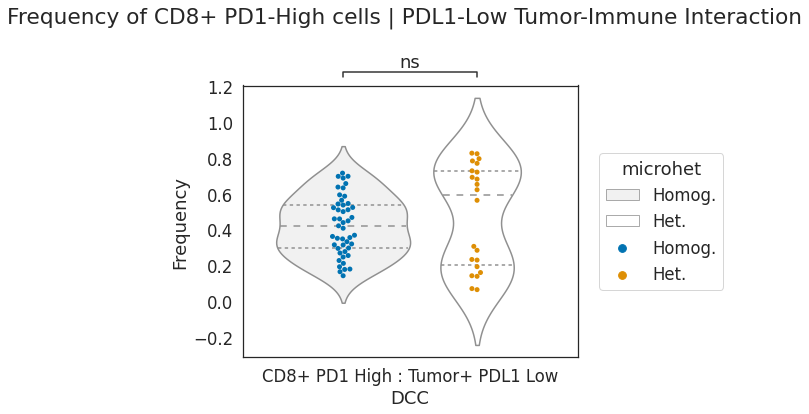

In [258]:
mode = 'inner'

crit = (dcc_counts['self'] == 'TI') & (dcc_counts['partner'] == 'Tumor+ PDL1 Low')
ref_ti_density = dcc_counts.loc[crit].groupby(['case_id','microhet','biopsySite','px','py','cell_type',])['Density'].sum().reset_index()
ref_ti_density = ref_ti_density.set_index(['case_id','px','py','cell_type'])['Density']
ref_ti_density.name = 'Total Density'


plot_data = dcc_counts.loc[crit]
plot_data = plot_data.set_index(['case_id','px','py','cell_type']).join(ref_ti_density).reset_index()
plot_data['Density Fraction'] = plot_data['Density']/plot_data['Total Density']
plot_data['Frequency'] = plot_data['Density Fraction']
plot_data['DCC'] = plot_data['detailed_cell_context'].astype(str)

tmp_sweep = sweep_exclusions_hardcode(plot_data)
for k, filtered_df in tmp_sweep.items():
    print(f'\n\n ====== \n {k}')
    
    plot_kws = {
        'order':None,
        'y':'Frequency',
        'x':'DCC',
        'order': None,
        'hue':'microhet',
        'hue_order':MH_ORDER,
        'data':filtered_df.loc[filtered_df['DCC'] == 'CD8+ PD1 High : Tumor+ PDL1 Low'],
    }

    i = plot_kws['data'][plot_kws['x']].unique()
    j = plot_kws['data'][plot_kws['hue']].unique()

    set_rc(int(6*len(i)),5, 1.5 )

    pairs = make_statannotations_pairs(i,j,mode)

    g = sns.violinplot(**plot_kws, inner='quartile',  color='white',)
    annotator = Annotator(g, pairs, **plot_kws)
    annotator.configure(test=TEST, text_format= TEXT_FORMAT, loc='outside')
    annotator.apply_and_annotate()


    g = sns.swarmplot(**plot_kws,dodge=True, )
    move_legend(g, xy=(1.25, 0.5))
    title_str = 'Frequency of CD8+ PD1-High cells | PDL1-Low Tumor-Immune Interaction'
    plt.suptitle(title_str, y=1.1)
    title_str = title_str.replace('\n','')
    f = f'./figures/{title_str}__({k})'
    flex_save(f, dpi=400)
    plt.show()
    
    unpacked_pvals = unpack_annotator(annotator)
    pval_str = f'[Supp] [({annotator.test} {annotator.text_format})] {title_str}__({k})'
    scattered_results[pval_str] = unpacked_pvals
    
    median_str = f'[Supp] [MH Medians] {title_str}__({k})'
    median_val = plot_kws['data'].groupby('microhet')[plot_kws['y']].median()
    scattered_results[median_str] = median_val

In [259]:
plot_data.groupby(['detailed_cell_context'])['Density'].describe().dropna()

,count,mean,std,min,25%,50%,75%,max
detailed_cell_context,,,,,,,,
CD8+ PD1 High : Tumor+ PDL1 Low,99.0,159.454545,208.506314,9.0,26.5,64.0,212.0,1060.0
CD8+ PD1 Low : Tumor+ PDL1 Low,99.0,158.686869,241.227078,12.0,47.5,73.0,127.0,1128.0


(array([77.,  6.,  1.,  2.,  3.,  2.,  3.,  0.,  2.,  3.]),
 array([1.7942703e-71, 1.0000000e-01, 2.0000000e-01, 3.0000000e-01,
        4.0000000e-01, 5.0000000e-01, 6.0000000e-01, 7.0000000e-01,
        8.0000000e-01, 9.0000000e-01, 1.0000000e+00]),
 <BarContainer object of 10 artists>)

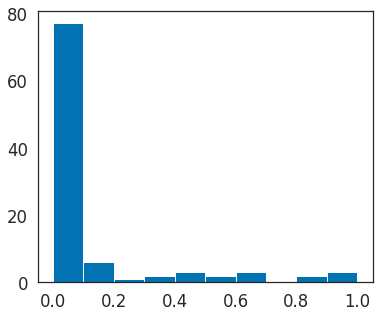

In [260]:
from scipy.stats import binomtest

pvals = []
for idx, d in plot_data.groupby(['case_id','px','py']):
    tmp = d.loc[d['detailed_cell_context'] == 'CD8+ PD1 High : Tumor+ PDL1 Low']
    pval = binomtest(tmp['Density'].item(), tmp['Total Density'].item()).pvalue
    pvals.append(pval)

plt.hist(np.array(pvals))

In [261]:
(np.array(pvals) < 0.05).mean()

0.7575757575757576

### DCC Densities 

In [262]:
ref_total_density = ct_counts.set_index(['case_id','px','py','cell_type'])['Density']
ref_total_density.name = 'Total Density'

tmp = dcc_counts.set_index(['case_id','px','py','cell_type']).join(ref_total_density).reset_index()
tmp['Density Fraction'] = tmp['Density']/tmp['Total Density']
tmp['DCC'] = tmp['detailed_cell_context'].astype(str)



 base
('Self', 'CD8+', 'CD8+ PD1 High : Self')
('Self', 'CD8+', 'CD8+ PD1 Low : Self')
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CD8+ PD1 Low : Self_Homog. vs. CD8+ PD1 Low : Self_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:7.527e-01 U_stat=1.242e+03
CD8+ PD1 High : Self_Homog. vs. CD8+ PD1 High : Self_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:3.589e-01 U_stat=1.067e+03


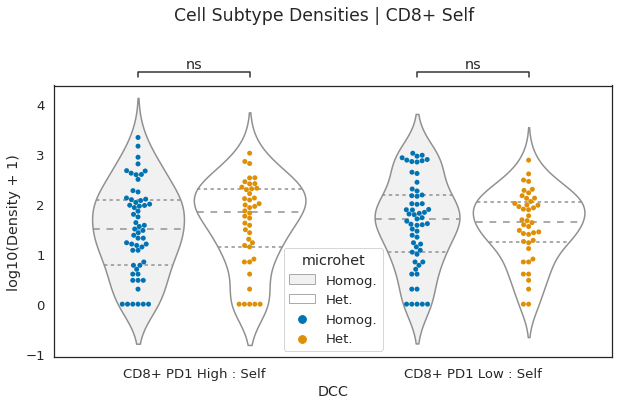



 Remove IP_19_K00367
('Self', 'CD8+', 'CD8+ PD1 High : Self')
('Self', 'CD8+', 'CD8+ PD1 Low : Self')
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CD8+ PD1 Low : Self_Homog. vs. CD8+ PD1 Low : Self_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:1.870e-01 U_stat=8.260e+02
CD8+ PD1 High : Self_Homog. vs. CD8+ PD1 High : Self_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:9.441e-03 U_stat=6.710e+02


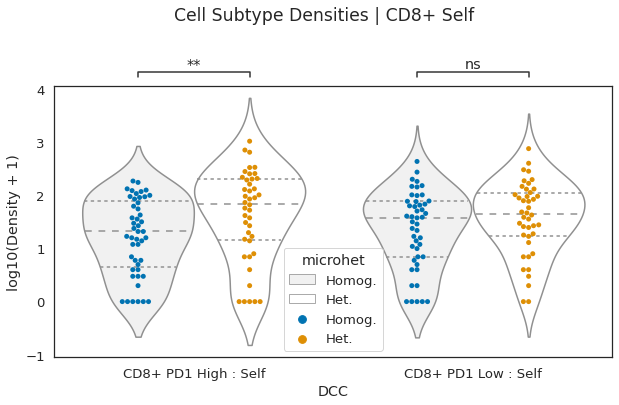



 Remove IP_19_K00367 and LN
('Self', 'CD8+', 'CD8+ PD1 High : Self')
('Self', 'CD8+', 'CD8+ PD1 Low : Self')
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CD8+ PD1 Low : Self_Homog. vs. CD8+ PD1 Low : Self_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:6.848e-01 U_stat=5.490e+02
CD8+ PD1 High : Self_Homog. vs. CD8+ PD1 High : Self_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:4.350e-01 U_stat=4.560e+02


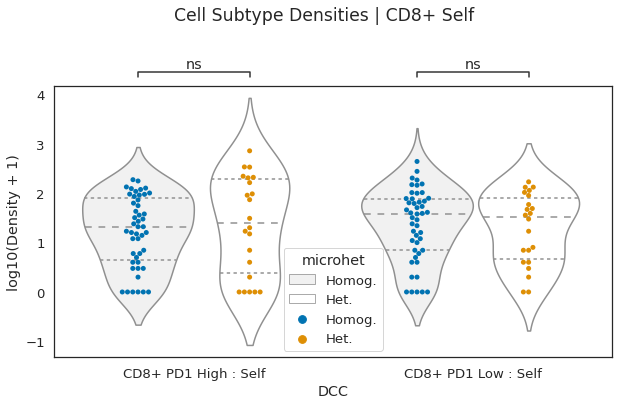



 base
('Self', 'Tumor+', 'Tumor+ PDL1 High : Self')
('Self', 'Tumor+', 'Tumor+ PDL1 Low : Self')
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Tumor+ PDL1 Low : Self_Homog. vs. Tumor+ PDL1 Low : Self_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:1.975e-01 U_stat=1.380e+03
Tumor+ PDL1 High : Self_Homog. vs. Tumor+ PDL1 High : Self_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:9.447e-02 U_stat=1.434e+03


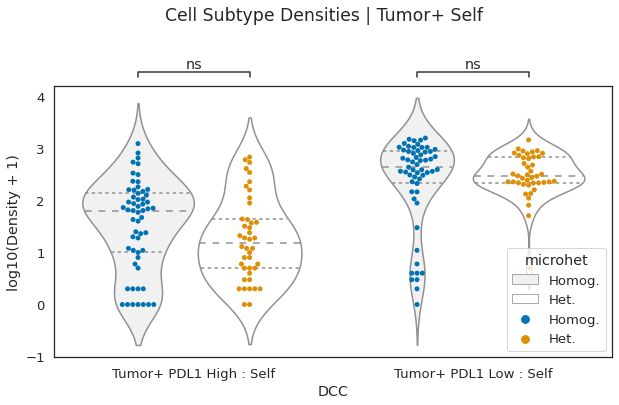



 Remove IP_19_K00367
('Self', 'Tumor+', 'Tumor+ PDL1 High : Self')
('Self', 'Tumor+', 'Tumor+ PDL1 Low : Self')
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Tumor+ PDL1 Low : Self_Homog. vs. Tumor+ PDL1 Low : Self_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:1.388e-03 U_stat=1.376e+03
Tumor+ PDL1 High : Self_Homog. vs. Tumor+ PDL1 High : Self_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:5.802e-04 U_stat=1.406e+03


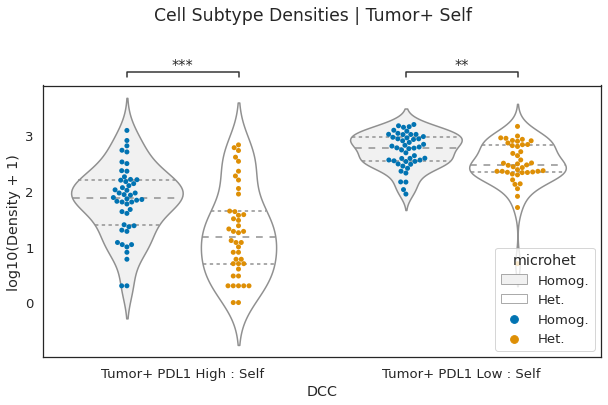



 Remove IP_19_K00367 and LN
('Self', 'Tumor+', 'Tumor+ PDL1 High : Self')
('Self', 'Tumor+', 'Tumor+ PDL1 Low : Self')
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Tumor+ PDL1 Low : Self_Homog. vs. Tumor+ PDL1 Low : Self_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:7.475e-01 U_stat=5.425e+02
Tumor+ PDL1 High : Self_Homog. vs. Tumor+ PDL1 High : Self_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:3.151e-01 U_stat=5.955e+02


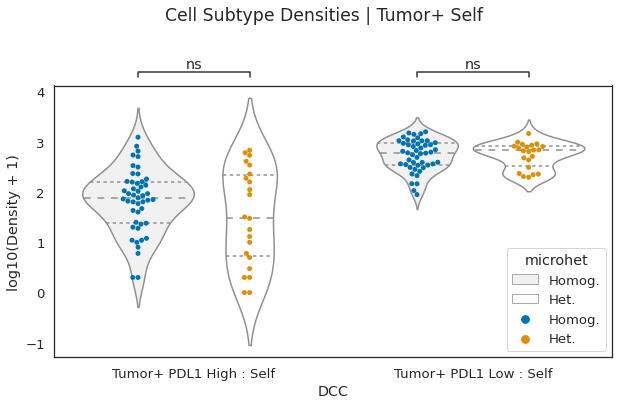



 base
('TI', 'CD8+', 'CD8+ PD1 High : Tumor+ PDL1 High')
('TI', 'CD8+', 'CD8+ PD1 High : Tumor+ PDL1 Low')
('TI', 'CD8+', 'CD8+ PD1 Low : Tumor+ PDL1 High')
('TI', 'CD8+', 'CD8+ PD1 Low : Tumor+ PDL1 Low')
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CD8+ PD1 Low : Tumor+ PDL1 High_Homog. vs. CD8+ PD1 Low : Tumor+ PDL1 High_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:3.551e-02 U_stat=1.494e+03
CD8+ PD1 High : Tumor+ PDL1 High_Homog. vs. CD8+ PD1 High : Tumor+ PDL1 High_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:2.533e-01 U_stat=1.358e+03
CD8+ PD1 High : Tumor+ PDL1 Low_Homog. vs. CD8+ PD1 High : Tumor+ PDL1 Low_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:1.069e-02 U_stat=8.360e+02
CD8+ PD1 Low : Tumor+ PDL1 Low_Homog. vs. CD8+ PD1 Low : Tumor+ PDL1 Low_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:6.217e-05 U_stat=6.310e+02


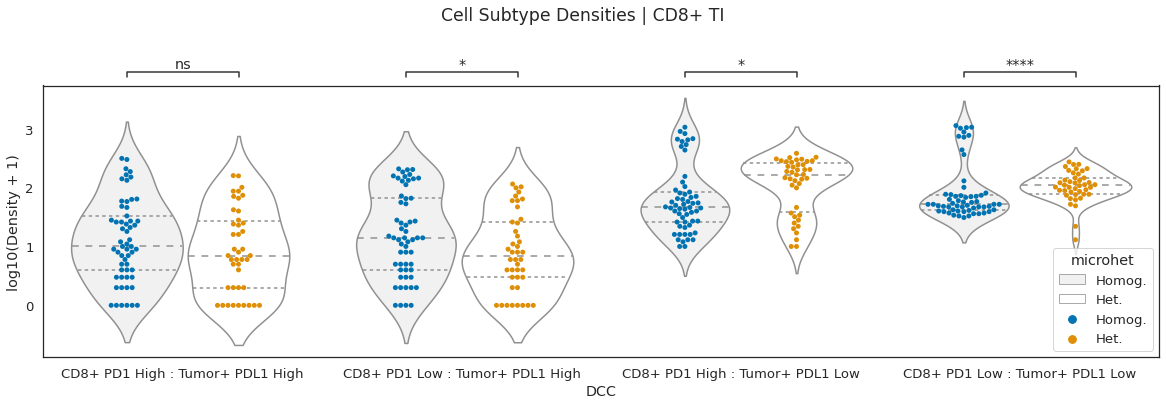



 Remove IP_19_K00367
('TI', 'CD8+', 'CD8+ PD1 High : Tumor+ PDL1 High')
('TI', 'CD8+', 'CD8+ PD1 High : Tumor+ PDL1 Low')
('TI', 'CD8+', 'CD8+ PD1 Low : Tumor+ PDL1 High')
('TI', 'CD8+', 'CD8+ PD1 Low : Tumor+ PDL1 Low')
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CD8+ PD1 Low : Tumor+ PDL1 High_Homog. vs. CD8+ PD1 Low : Tumor+ PDL1 High_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:4.461e-01 U_stat=1.080e+03
CD8+ PD1 High : Tumor+ PDL1 High_Homog. vs. CD8+ PD1 High : Tumor+ PDL1 High_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:9.212e-01 U_stat=9.745e+02
CD8+ PD1 High : Tumor+ PDL1 Low_Homog. vs. CD8+ PD1 High : Tumor+ PDL1 Low_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:2.739e-06 U_stat=4.160e+02
CD8+ PD1 Low : Tumor+ PDL1 Low_Homog. vs. CD8+ PD1 Low : Tumor+ PDL1 Low_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:1.829e-10 U_sta

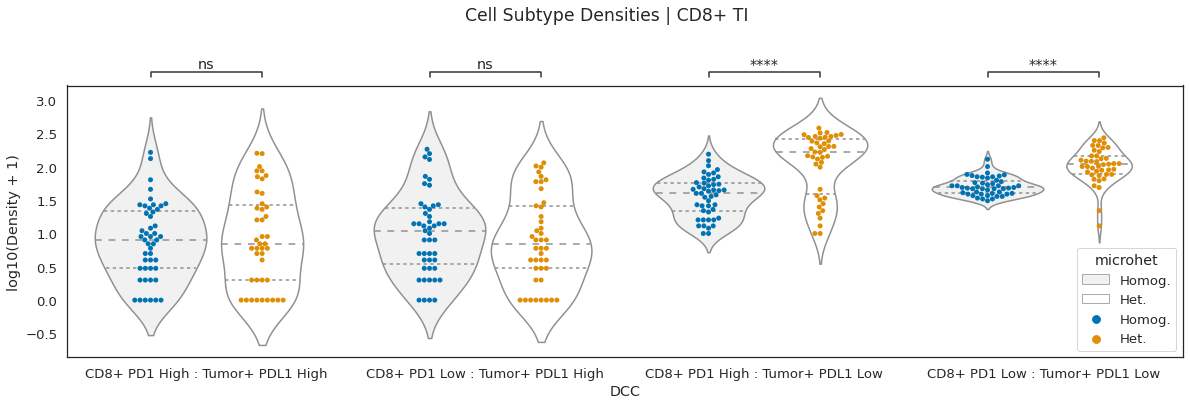



 Remove IP_19_K00367 and LN
('TI', 'CD8+', 'CD8+ PD1 High : Tumor+ PDL1 High')
('TI', 'CD8+', 'CD8+ PD1 High : Tumor+ PDL1 Low')
('TI', 'CD8+', 'CD8+ PD1 Low : Tumor+ PDL1 High')
('TI', 'CD8+', 'CD8+ PD1 Low : Tumor+ PDL1 Low')
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CD8+ PD1 Low : Tumor+ PDL1 High_Homog. vs. CD8+ PD1 Low : Tumor+ PDL1 High_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:2.456e-01 U_stat=6.075e+02
CD8+ PD1 High : Tumor+ PDL1 High_Homog. vs. CD8+ PD1 High : Tumor+ PDL1 High_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:4.620e-01 U_stat=5.745e+02
CD8+ PD1 High : Tumor+ PDL1 Low_Homog. vs. CD8+ PD1 High : Tumor+ PDL1 Low_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:1.662e-01 U_stat=4.090e+02
CD8+ PD1 Low : Tumor+ PDL1 Low_Homog. vs. CD8+ PD1 Low : Tumor+ PDL1 Low_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:4.815e-0

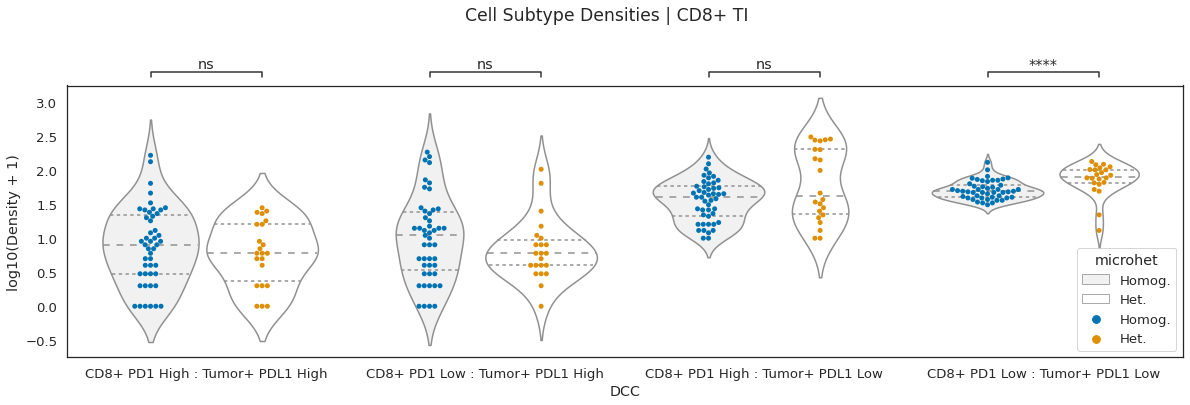



 base
('TI', 'Tumor+', 'Tumor+ PDL1 High : CD8+ PD1 High')
('TI', 'Tumor+', 'Tumor+ PDL1 High : CD8+ PD1 Low')
('TI', 'Tumor+', 'Tumor+ PDL1 Low : CD8+ PD1 High')
('TI', 'Tumor+', 'Tumor+ PDL1 Low : CD8+ PD1 Low')
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Tumor+ PDL1 High : CD8+ PD1 Low_Homog. vs. Tumor+ PDL1 High : CD8+ PD1 Low_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:1.831e-01 U_stat=1.386e+03
Tumor+ PDL1 High : CD8+ PD1 High_Homog. vs. Tumor+ PDL1 High : CD8+ PD1 High_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:5.260e-01 U_stat=1.287e+03
Tumor+ PDL1 Low : CD8+ PD1 High_Homog. vs. Tumor+ PDL1 Low : CD8+ PD1 High_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:1.542e-05 U_stat=5.860e+02
Tumor+ PDL1 Low : CD8+ PD1 Low_Homog. vs. Tumor+ PDL1 Low : CD8+ PD1 Low_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:1.519e-04 U_stat=6.615

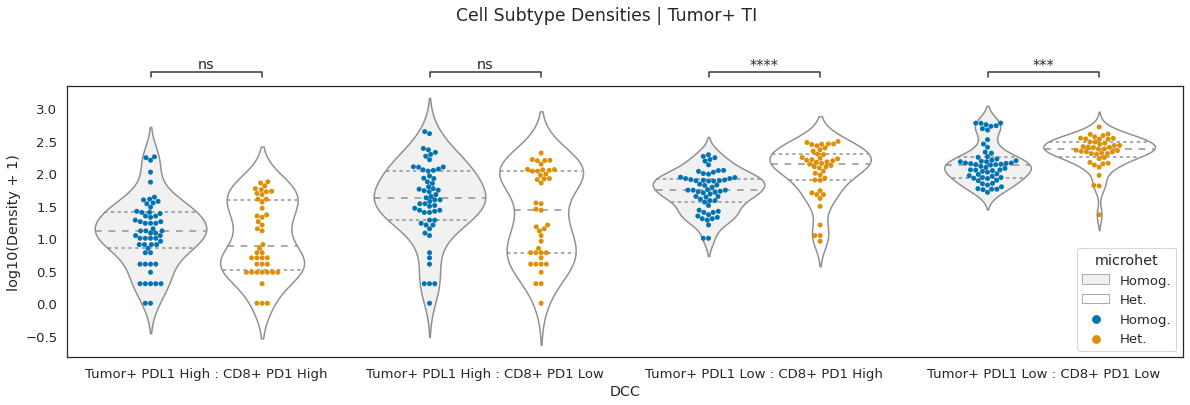



 Remove IP_19_K00367
('TI', 'Tumor+', 'Tumor+ PDL1 High : CD8+ PD1 High')
('TI', 'Tumor+', 'Tumor+ PDL1 High : CD8+ PD1 Low')
('TI', 'Tumor+', 'Tumor+ PDL1 Low : CD8+ PD1 High')
('TI', 'Tumor+', 'Tumor+ PDL1 Low : CD8+ PD1 Low')
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Tumor+ PDL1 High : CD8+ PD1 Low_Homog. vs. Tumor+ PDL1 High : CD8+ PD1 Low_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:7.672e-01 U_stat=1.024e+03
Tumor+ PDL1 High : CD8+ PD1 High_Homog. vs. Tumor+ PDL1 High : CD8+ PD1 High_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:3.677e-01 U_stat=1.097e+03
Tumor+ PDL1 Low : CD8+ PD1 High_Homog. vs. Tumor+ PDL1 Low : CD8+ PD1 High_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:6.950e-05 U_stat=5.025e+02
Tumor+ PDL1 Low : CD8+ PD1 Low_Homog. vs. Tumor+ PDL1 Low : CD8+ PD1 Low_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:3.265e-

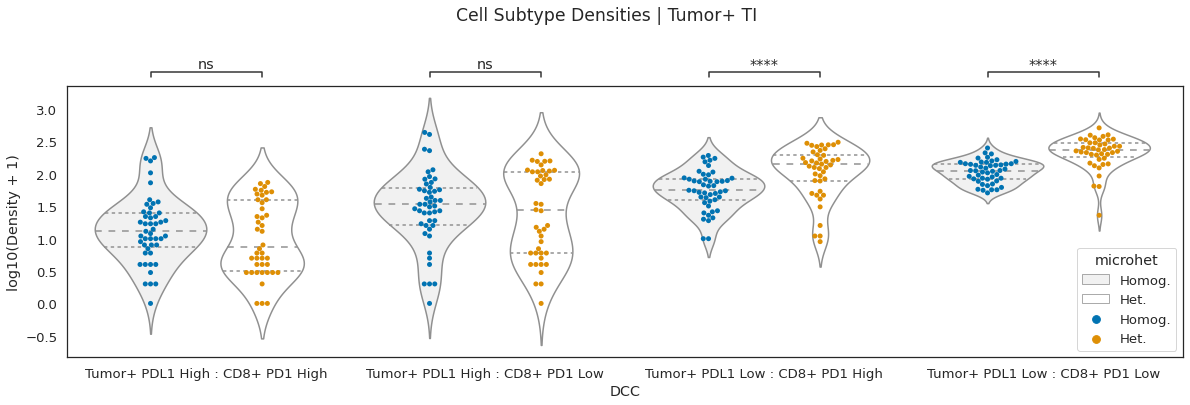



 Remove IP_19_K00367 and LN
('TI', 'Tumor+', 'Tumor+ PDL1 High : CD8+ PD1 High')
('TI', 'Tumor+', 'Tumor+ PDL1 High : CD8+ PD1 Low')
('TI', 'Tumor+', 'Tumor+ PDL1 Low : CD8+ PD1 High')
('TI', 'Tumor+', 'Tumor+ PDL1 Low : CD8+ PD1 Low')
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Tumor+ PDL1 High : CD8+ PD1 Low_Homog. vs. Tumor+ PDL1 High : CD8+ PD1 Low_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:7.040e-01 U_stat=5.470e+02
Tumor+ PDL1 High : CD8+ PD1 High_Homog. vs. Tumor+ PDL1 High : CD8+ PD1 High_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:2.020e-01 U_stat=6.165e+02
Tumor+ PDL1 Low : CD8+ PD1 High_Homog. vs. Tumor+ PDL1 Low : CD8+ PD1 High_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:8.443e-02 U_stat=3.825e+02
Tumor+ PDL1 Low : CD8+ PD1 Low_Homog. vs. Tumor+ PDL1 Low : CD8+ PD1 Low_Het.: Mann-Whitney-Wilcoxon test two-sided, P_val:

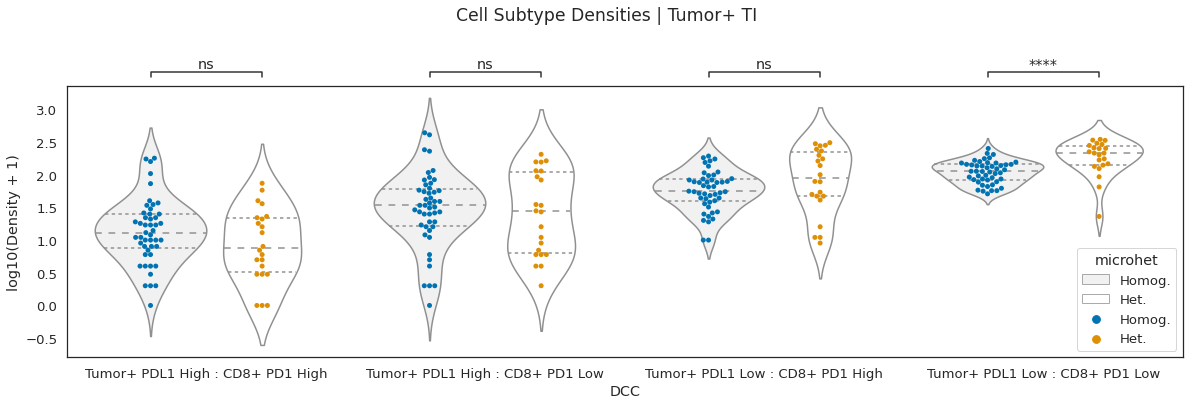

In [263]:
plot_marginals = False
fit_intercept = True
tmp_sweep = sweep_exclusions_hardcode(tmp)
for self_flag in ['Self','TI']:
    for cell in ['CD8+','Tumor+']:
        for k, filtered_df in tmp_sweep.items():
            print(f'\n\n ====== \n {k}')

            residual_agg = pd.DataFrame()
            crit = (filtered_df['cell_type'] == cell) & (filtered_df['self'] == self_flag)
            for idx, subsub in filtered_df.loc[crit].groupby(['self','cell_type','DCC']):
                print(idx)
                regress_out(subsub, 'Total Density','Density', fit_intercept=fit_intercept)
                subsub['Residual Density'] = subsub['residual_Density_cond_Total Density']
                subsub['Predicted Density'] = subsub['pred_Density_cond_Total Density']

                for col in ['Residual Density','Predicted Density']:
                    add_log10_density(subsub, col)


                residual_agg = pd.concat([residual_agg, subsub])

            if (self_flag == 'TI') & (cell == 'CD8+'):
                col_order = [
                    'CD8+ PD1 High : Tumor+ PDL1 High',
                    'CD8+ PD1 Low : Tumor+ PDL1 High',
                    'CD8+ PD1 High : Tumor+ PDL1 Low',
                    'CD8+ PD1 Low : Tumor+ PDL1 Low'
                ]
            else:
                col_order = np.sort(residual_agg['DCC'].unique())

            residual_agg['Residual Density (Transformed)'] = residual_agg['Residual Density'].apply(lambda x: np.sign(x) * np.log10(np.clip(np.abs(x), a_min=1, a_max=None)))

            # for partner, df in residual_agg.groupby('partner'):

            for (y, mode) in [('log10(Density + 1)','inner')]:
                plot_kws = {
                    'order':None,
                    'y':y,
                    'x':'DCC',
                    'order': col_order,
                    'hue':'microhet',
                    'hue_order':MH_ORDER,
                    'data':residual_agg,
                }

                i = plot_kws['data'][plot_kws['x']].unique()
                j = plot_kws['data'][plot_kws['hue']].unique()

                set_rc(int(5*len(i)),5, 1.2 )

                pairs = make_statannotations_pairs(i,j,mode)

                g = sns.violinplot(**plot_kws, inner='quartile',  color='white')
                annotator = Annotator(g, pairs, **plot_kws)
                annotator.configure(test=TEST, text_format= TEXT_FORMAT, loc='outside')
                annotator.apply_and_annotate()

                g = sns.swarmplot(**plot_kws,dodge=True, )
                
                title_str = f'Cell Subtype Densities | {cell} {self_flag}'
                plt.suptitle(title_str, y=1.1)
                title_str = title_str.replace('\n','')
                f = f'./figures/{title_str}__({k})'
                flex_save(f, dpi=400)
                plt.show()

                unpacked_pvals = unpack_annotator(annotator)
                pval_str = f'[Supp] [({annotator.test} {annotator.text_format})] {title_str}__({k})'
                scattered_results[pval_str] = unpacked_pvals

                median_str = f'[Supp] [MH Medians] {title_str}__({k})'
                median_val = plot_kws['data'].groupby('microhet')[plot_kws['y']].median()
                scattered_results[median_str] = median_val
    

In [264]:
def flatten_results(x):
    if type(x) == dict:
        return x
    elif type(x) == pd.Series:
        return x.to_dict()
    else:
        return {'val':x}

In [265]:
flattened_results = {k:flatten_results(v) for k,v in scattered_results.items()}

In [266]:
pd.Series(flattened_results).to_csv('./topk_pval_result_agg.csv')